# Init

In [2]:
import numpy as np
import h5py
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from sqgbrwa.utils import *
from sqgbrwa.pulse_envelopes import *

In [2]:
# Ensure font sizes are large enough to read
poster_sizes = [24, 26, 28]
presentation_sizes = [16, 18, 20]
SMALL_SIZE = presentation_sizes[0]
MEDIUM_SIZE = presentation_sizes[1]
BIGGER_SIZE = presentation_sizes[2]

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [ ]:
base_dir = "U:/AndersenLab/quantify-data/" ## This should refer to the folder that contains the data
gates_per_clifford = 1.875
figure_data = dict()

# Residual ZZ

In [205]:
times = np.arange(120e-9, 50_000e-9, 500e-9)

def fun(x, a, b, tau, w, phi):
    return a + b*np.exp(-x/tau)*np.sin(w*x + phi)

In [213]:
data_folders = [
    get_data_folders(base_dir+"20241128/", start=142923, stop=142923)[0],
    get_data_folders(base_dir+"20241128/", start=143938, stop=143938)[0],
    get_data_folders(base_dir+"20241128/", start=144952, stop=144952)[0],
    get_data_folders(base_dir+"20241128/", start=151023, stop=151023)[0],
]

T2 = 0.4625665204706893 \pm 2.155741441587261 kHz


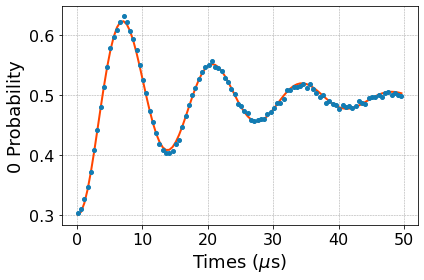

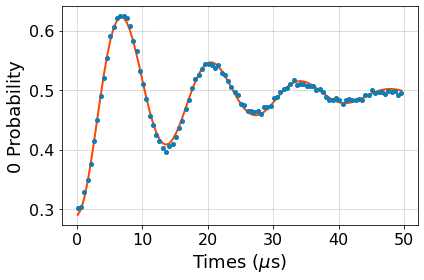

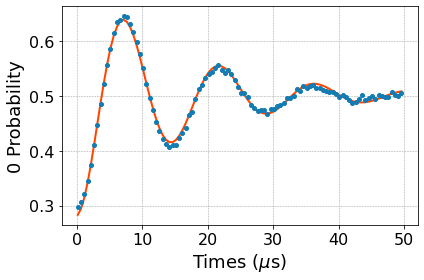

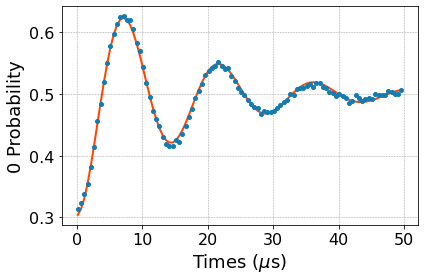

In [219]:
results_T2 = np.zeros(4)
results_std = np.zeros(4)

for i,data_folder in enumerate(data_folders):
    # Get 0 counts
    with h5py.File(data_folder+"/dataset.hdf5", "r") as f:
        counts_0 = np.array(list(f["counts_0"]))

    # Fit
    x0 = [np.mean(counts_0), np.max(counts_0)-np.min(counts_0), 15e-6, 2*np.pi*0.07e6, np.pi]
    popt,pcov = curve_fit(fun, times, counts_0, p0=x0)
    perr = np.sqrt(np.diag(pcov))

    results_T2[i] = popt[3]
    results_std[i] = perr[3]

    # Make figure
    fig,ax = fig_prepare(r"Times ($\mu$s)", "0 Probability")
    ax.plot(times*1e6, fun(times, *popt), linestyle="-",color=colors["red"],linewidth=2)
    ax.plot(times*1e6, counts_0, linestyle="",color=colors["blue"],marker=".",markersize=8)
    fig.tight_layout()

T2 = (results_T2[0] + results_T2[3] - results_T2[1] - results_T2[2]) / 2
err = np.sum(results_std) / 2
print(rf"T2 = {T2*1e-3} \pm {err*1e-3} kHz")

# T1/T2E
Here, I collect many T1/T2E measurements to get an average

In [273]:
data_folders_T1 = [
    ("20241213/", 220351),
    ("20241213/", 235343),
    ("20241214/",  15206),
    ("20241214/",  35505),
    ("20241214/",  60224),
    ("20241213/", 121612),
    ("20241213/", 140814),
    ("20241213/", 160251),
    ("20241213/", 180245),
    ("20241213/", 200623),
    ("20241220/", 120811),
    ("20241220/", 154351),
    ("20241220/", 192253),
    ("20241220/", 230514),
    ("20241221/",  23617),
    ("20241219/", 163221),
    ("20241219/", 203333),
    ("20241220/",   3145),
    ("20241220/",  42120),
    ("20241220/",  83134),
]

data_folders_T2E = [
    ("20241213/", 220658),
    ("20241213/", 235652),
    ("20241214/",  15524),
    ("20241214/",  35824),
    ("20241214/",  60533),
    ("20241213/", 121912),
    ("20241213/", 141116),
    ("20241213/", 160554),
    ("20241213/", 180552),
    ("20241213/", 200939),
    ("20241220/", 121246),
    ("20241220/", 154833),
    ("20241220/", 192732),
    ("20241220/", 230957),
    ("20241221/",  24050),
    ("20241219/", 163650),
    ("20241219/", 203814),
    ("20241220/",   3615),
    ("20241220/",  42552),
    ("20241220/",  83608),
]

data_folders_T1 = [get_data_folders(base_dir+x[0], start=x[1], stop=x[1])[0] for x in data_folders_T1]
data_folders_T2E = [get_data_folders(base_dir+x[0], start=x[1], stop=x[1])[0] for x in data_folders_T2E]

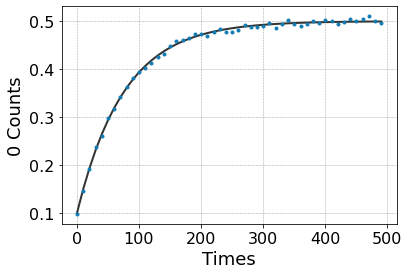

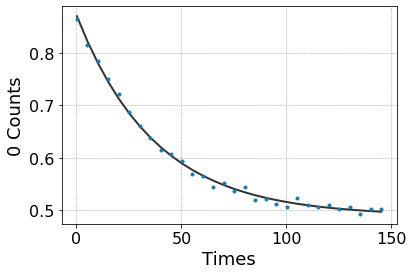

In [276]:
results_T1  = []
results_T2E = []

times_T1  = np.arange(200e-9, 500e-6, 10e-6)
times_T2E = np.arange(200e-9, 150e-6, 5e-6)

def fun(x,a,b,c):
    return a*np.exp(-x/b) + c

for i in range(len(data_folders_T1)):
    data_folder_T1 = data_folders_T1[i]
    data_folder_T2E = data_folders_T2E[i]

    # Get counts
    with h5py.File(data_folder_T1+"/dataset.hdf5", "r") as f:
        counts_0_T1 = np.array(list(f["counts_0"]))
    with h5py.File(data_folder_T2E+"/dataset.hdf5", "r") as f:
        counts_0_T2E = np.array(list(f["counts_0"]))

    x0_T1  = [counts_0_T1[0]-counts_0_T1[-1], 70e-6, counts_0_T1[-1]]
    x0_T2E = [-counts_0_T2E[-1], 35e-6, counts_0_T2E[-1]]

    popt_T1, _ = curve_fit(fun, times_T1,  counts_0_T1,  p0=x0_T1)
    popt_T2E,_ = curve_fit(fun, times_T2E, counts_0_T2E, p0=x0_T2E)

    results_T1.append(popt_T1[1])
    results_T2E.append(popt_T2E[1])

    if i==0:
        fig,ax = fig_prepare("Times", "0 Counts")
        ax.plot(times_T1*1e6, fun(times_T1, *popt_T1), color="#333", linewidth=2)
        ax.plot(times_T1*1e6, counts_0_T1, linestyle="", marker=".", color=colors["blue"])

        fig,ax = fig_prepare("Times", "0 Counts")
        ax.plot(times_T2E*1e6, fun(times_T2E, *popt_T2E), color="#333", linewidth=2)
        ax.plot(times_T2E*1e6, counts_0_T2E, linestyle="", marker=".", color=colors["blue"])

In [281]:
np.mean(results_T1), np.mean(results_T2E)

(7.544877096912856e-05, 3.758105042675956e-05)

# Protocol 1 & 2 & 3 vs coherence limit

In [7]:
tgs = np.array([40, 33.333, 26.666, 20, 13.333])

# Fit exponential
def fun(m, A0, p, B0):
    return A0*p**m + B0

In [8]:
# Load RB and IRB data
data_folders = [
    ## Protocol 1
    # 40 ns
    ("20241227/", 210514),
    ("20241227/", 222818),
    # 33.333 ns
    ("20241227/", 120552),
    ("20241227/", 132538),
    # 26.666 ns
    ("20241226/", 222247),
    ("20241226/", 233953),
    # 20 ns
    ("20241226/", 140432),
    ("20241226/", 151616),
    # 13.333 ns
    ("20241225/", 173309),
    ("20241225/", 184627),

    ## Protocol 2
    # 40 ns
    ("20241224/", 174017),
    ("20241224/", 201931),
    # 33.333 ns
    ("20241224/", 92909),
    ("20241224/", 112754),
    # 26.666 ns
    ("20241223/", 163451),
    ("20241223/", 183210),
    # 20 ns
    ("20241222/", 160044),
    ("20241222/", 175215),
    # 13.333 ns
    ("20241225/", 81301),
    ("20241225/", 95119),

    ## Protocol 2
    # # 40 ns
    # ("20241228/", 213255),
    # ("20241228/", 141354),
    # # 33.333 ns
    # ("20241229/", 142203),
    # ("20241229/", 154313),
    # # 26.666 ns
    # ("20241229/", 221613),
    # ("20241229/", 233637),
    # # 20 ns
    # ("20241230/", 120216),
    # ("20241230/", 132325),
    # # 13.333 ns
    # ("20241230/", 220159),
    # ("20241230/", 231843),

    ## Protocol 3
    # 40 ns
    ("20250109/", 200912),
    ("20250109/", 235813),
    # 33.333 ns
    ("20250109/", 94247),
    ("20250109/", 115049),
    # 26.666 ns
    ("20250108/", 231250),
    ("20250109/", 12923),
    # 20 ns
    ("20250108/", 113442),
    ("20250108/", 134251),
    # 13.333 ns
    ("20250110/", 112016),
    ("20250110/", 130553),

    ## Protocol 4
    # 13.333 ns
    ("20250114/", 215941),
    ("20250110/", 130553),
]

data_folders = [get_data_folders(base_dir+x[0], start=x[1], stop=x[1])[0] for x in data_folders]

Mmax = [
    ## Protocol 1
    (500, 2000),                # 40
    (400, 2000),                # 33.333
    (300, 2000),                # 26.666
    (200, 2000),                # 20
    (200, 2000),                # 13.333

    ## Protocol 2
    (2000, 2000),                # 40
    (2000, 2000),                # 33.333
    (2000, 2000),                # 26.666
    (2000, 2000),                # 20
    (1250, 1250),                # 13.333

    ## Protocol 2
    # (500, 500),                # 40
    # (500, 500),                # 33.333
    # (500, 500),                # 26.666
    # (500, 500),                # 20
    # (500, 500),                # 13.333

    ## Protocol 3
    (2000, 2000),                # 40
    (2000, 2000),                # 33.333
    (2000, 2000),                # 26.666
    (2000, 2000),                # 20
    (1250, 1250),                # 13.333

    # Protocol 4
    (2000, 2000)
]
K = 50

In [9]:
results_errors = np.zeros(32)
results_stds   = np.zeros(32)

weights = np.arange(12)
M = (np.array([sum(weights[:(i+1)])/np.sum(weights) for i in range(12)]) * 2000).astype(int)
M[0] = 1
figure_data[1] = dict(
    x0 = np.copy(M),
    y0 = np.zeros((len(data_folders)//2, 3)),
    y1 = np.zeros((len(data_folders)//2, 12))
)

In [10]:
for i in range(16):
    if isinstance(Mmax[i], tuple):
        Mmax_rb = Mmax[i][0]
        Mmax_prb = Mmax[i][1]
    else:
        Mmax_rb = Mmax_prb = Mmax[i]
    weights = np.arange(12)
    M_rb = (np.array([sum(weights[:(i+1)])/np.sum(weights) for i in range(12)]) * Mmax_rb).astype(int)
    M_rb[0] = 1
    M_prb = (np.array([sum(weights[:(i+1)])/np.sum(weights) for i in range(12)]) * Mmax_prb).astype(int)
    M_prb[0] = 1

    # Get 0 counts
    with h5py.File(data_folders[2*i]+"/dataset.hdf5", "r") as f:
        counts_0_rb = np.array(list(f["counts_0"]))
    with h5py.File(data_folders[2*i+1]+"/dataset.hdf5", "r") as f:
        counts_0_prb = np.array(list(f["counts_0"]))

    outputs_z = counts_0_prb[0::3].reshape((len(M_prb),K))
    outputs_x = counts_0_prb[1::3].reshape((len(M_prb),K))
    outputs_y = counts_0_prb[2::3].reshape((len(M_prb),K))

    # Convert counts to expectations values
    outputs_z = -(2*outputs_z - 1)
    outputs_x = -(2*outputs_x - 1)
    outputs_y = -(2*outputs_y - 1)

    results_rb  = counts_0_rb.reshape((len(M_rb),K))
    results_prb = np.sqrt(outputs_z**2 + outputs_x**2 + outputs_y**2)

    # Average 0 counts and fit
    outputs_mean_rb  = np.mean(results_rb, axis=1)
    outputs_mean_prb = np.mean(results_prb, axis=1)
    figure_data[1]["y1"][i,:] = outputs_mean_rb

    # Fit exponential
    popt_rb,pcov_rb   = curve_fit(fun, M_rb, outputs_mean_rb,  p0=[0.25,0.999,0.5])
    popt_prb,pcov_prb = curve_fit(fun, M_prb, outputs_mean_prb, p0=[0.25,0.999,0.5])
    perr_rb = np.sqrt(np.diag(pcov_rb))
    perr_prb = np.sqrt(np.diag(pcov_prb))
    figure_data[1]["y0"][i,:] = popt_rb

    # Extract error
    results_errors[2*i] = (1-popt_rb[1])/2/gates_per_clifford
    results_errors[2*i+1] = (1-popt_prb[1])/2/gates_per_clifford
    results_stds[2*i] = (perr_rb[1])/2/gates_per_clifford
    results_stds[2*i+1] = (perr_prb[1])/2/gates_per_clifford

In [11]:
xx = 1e-9 * np.linspace(np.min(tgs), np.max(tgs), 101)
coherence_limit = 0.5 + 1/6 * np.exp(-xx/75e-6) + 1/3*np.exp(-xx/37e-6)
coherence_limit = (1-coherence_limit)

results_purity_p3 = results_errors[21:31:2]

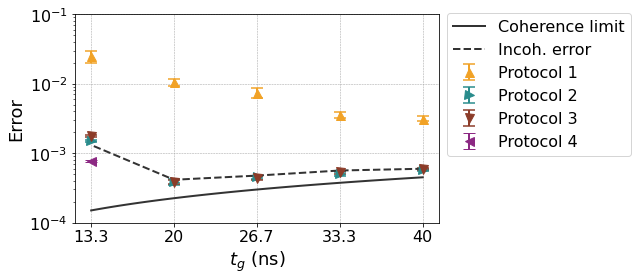

In [ ]:
color_list = ["#f1a226", "#298c8c", "#8C3C29"]

fig,ax = fig_prepare(r"$t_g$ (ns)", "Error", yscale="log")
# ax.plot(xx*1e9, coherence_limit, color="#666")
(_, caps1, _) = ax.errorbar(tgs, results_errors[:10:2], yerr=results_stds[:10:2], linestyle="", marker="^", markersize=9, capsize=6, linewidth=2, color=color_list[0], label="Protocol 1")
(_, caps2, _) = ax.errorbar(tgs, results_errors[10:20:2], yerr=results_stds[10:20:2], linestyle="", marker=">", markersize=9, capsize=6, linewidth=2, color=color_list[1], label="Protocol 2")
(_, caps3, _) = ax.errorbar(tgs, results_errors[20:30:2], yerr=results_stds[20:30:2], linestyle="", marker="v", markersize=9, capsize=6, linewidth=2, color=color_list[2], label="Protocol 3")
ax.errorbar(tgs[-1], results_errors[-2], yerr=results_stds[-2], linestyle="", marker="<", markersize=9, capsize=6, linewidth=2, color="#8C2983", label="Protocol 4")
ax.plot(xx*1e9, coherence_limit, linewidth=2, color="#333", label="Coherence limit")
ax.plot(tgs, results_purity_p3, linewidth=2, color="#333", linestyle="--", label="Incoh. error")

for cap in caps1+caps2+caps3:
    cap.set_markeredgewidth(1.5)

ax.set_xticks(ticks=np.flip(tgs), 
              labels=[13.3, 20, 26.7, 33.3, 40])
ax.legend(loc=[1.02,0.32])
ax.set_yticks([1e-4,1e-3,1e-2,1e-1])
fig.set_size_inches(9,4)
fig.tight_layout()

# fig.savefig("protocol123-rb-prb.png", dpi=200)

In [13]:
figure_data[0] = dict(
    x0=np.copy(tgs),
    y0=np.copy(results_errors),
    y1=np.copy(results_stds),
)

# Error budgets

In [28]:
# Load sim data
extended_data1 = load_dataset("20250124-171107", folder_name="extended-data", json_fname="extended_data")
extended_data2 = load_dataset("20250123-194712", folder_name="extended-data", json_fname="extended_data")
extended_data3 = load_dataset("20250126-133937", folder_name="extended-data", json_fname="extended_data")
extended_data = dict()
extended_data["error_budget"] = extended_data1["error_budget"] | extended_data2["error_budget"] | extended_data3["error_budget"]

In [29]:
tgs = extended_data["error_budget"]["x0"]

results_p1_tls_pi_error  = 1 - extended_data["error_budget"]["y0"]
results_p1_tls_pi2_error = 1 - extended_data["error_budget"]["y1"]
results_p1_4ls_pi_error  = 1 - extended_data["error_budget"]["y4"]
results_p1_4ls_pi2_error = 1 - extended_data["error_budget"]["y5"]
results_p2_tls_pi_error  = 1 - np.mean(extended_data["error_budget"]["y8"], axis=1)
results_p2_tls_pi2_error = 1 - np.mean(extended_data["error_budget"]["y9"], axis=1)
results_p2_4ls_pi_error  = 1 - np.mean(extended_data["error_budget"]["y14"], axis=1)
results_p2_4ls_pi2_error = 1 - np.mean(extended_data["error_budget"]["y15"], axis=1)
results_p3_4ls_pi_error  = 1 - np.mean(extended_data["error_budget"]["y22"], axis=1)
results_p3_4ls_pi2_error = 1 - np.mean(extended_data["error_budget"]["y23"], axis=1)
results_p4_tls_pi_error  = 1 - np.mean(extended_data["error_budget"]["y32"], axis=1)
results_p4_tls_pi2_error = 1 - np.mean(extended_data["error_budget"]["y33"], axis=1)
results_p4_4ls_pi_error  = 1 - np.mean(extended_data["error_budget"]["y40"], axis=1)
results_p4_4ls_pi2_error = 1 - np.mean(extended_data["error_budget"]["y41"], axis=1)

leakage_p1_pi  = np.mean(extended_data["error_budget"]["y30"], axis=1)
leakage_p1_pi2 = np.mean(extended_data["error_budget"]["y31"], axis=1)
leakage_p2_pi  = np.mean(extended_data["error_budget"]["y20"], axis=1)
leakage_p2_pi2 = np.mean(extended_data["error_budget"]["y21"], axis=1)
leakage_p3_pi  = np.mean(extended_data["error_budget"]["y28"], axis=1)
leakage_p3_pi2 = np.mean(extended_data["error_budget"]["y29"], axis=1)
leakage_p4_pi  = np.mean(extended_data["error_budget"]["y50"], axis=1)
leakage_p4_pi2 = np.mean(extended_data["error_budget"]["y51"], axis=1)

coherence_limit = 0.5 + 1/6 * np.exp(-xx/75e-6) + 1/3*np.exp(-xx/37e-6)
coherence_limit = (1-coherence_limit)

In [30]:
errors_p1_measured = np.flip(results_errors[:10:2])
errors_p2_measured = np.flip(results_errors[10:20:2])
errors_p3_measured = np.flip(results_errors[20:30:2])
errors_p4_measured = np.zeros(len(tgs))
errors_p4_measured[0] = results_errors[-2]

prb_p1_measured = np.flip(results_errors[1:11:2])
prb_p2_measured = np.flip(results_errors[11:21:2])
prb_p3_measured = np.flip(results_errors[21:31:2])
prb_p4_measured = np.zeros(len(tgs))
prb_p4_measured[0] = results_errors[-1]

In [31]:
# p1 error budget
error_coherent_p1_pi = results_p1_4ls_pi_error
error_coherent_p1_pi2 = results_p1_4ls_pi2_error
error_higher_levels_p1_pi = error_coherent_p1_pi - results_p1_tls_pi_error
error_higher_levels_p1_pi2 = error_coherent_p1_pi2 - results_p1_tls_pi2_error

# p2 error budget
error_coherent_p2_pi = results_p2_4ls_pi_error
error_coherent_p2_pi2 = results_p2_4ls_pi2_error
error_higher_levels_p2_pi = error_coherent_p2_pi - results_p2_tls_pi_error
error_higher_levels_p2_pi2 = error_coherent_p2_pi2 - results_p2_tls_pi2_error

# p3 error budget
error_coherent_p3_pi = results_p3_4ls_pi_error
error_coherent_p3_pi2 = results_p3_4ls_pi2_error
error_higher_levels_p3_pi = error_coherent_p3_pi - results_p2_tls_pi_error
error_higher_levels_p3_pi2 = error_coherent_p3_pi2 - results_p2_tls_pi2_error

# p4 error budget
error_coherent_p4_pi = results_p4_4ls_pi_error
error_coherent_p4_pi2 = results_p4_4ls_pi2_error
error_higher_levels_p4_pi = error_coherent_p4_pi - results_p4_tls_pi_error
error_higher_levels_p4_pi2 = error_coherent_p4_pi2 - results_p4_tls_pi2_error

In [32]:
# Calculate averages over pi and pi2
error_non_rwa_p1 = (results_p1_tls_pi_error + results_p1_tls_pi2_error)/2
error_higher_levels_p1 = (error_higher_levels_p1_pi + error_higher_levels_p1_pi2)/2
error_leakage_p1 = (leakage_p1_pi + leakage_p1_pi2)/2

error_non_rwa_p2 = (results_p2_tls_pi_error + results_p2_tls_pi2_error)/2
error_higher_levels_p2 = (error_higher_levels_p2_pi + error_higher_levels_p2_pi2)/2
error_leakage_p2 = (leakage_p2_pi + leakage_p2_pi2)/2

error_non_rwa_p3 = (results_p2_tls_pi_error + results_p2_tls_pi2_error)/2
error_higher_levels_p3 = (error_higher_levels_p3_pi + error_higher_levels_p3_pi2)/2
error_leakage_p3 = (leakage_p3_pi + leakage_p3_pi2)/2

error_non_rwa_p4 = (results_p4_tls_pi_error + results_p4_tls_pi2_error)/2
error_higher_levels_p4 = (error_higher_levels_p4_pi + error_higher_levels_p4_pi2)/2
error_leakage_p4 = (leakage_p4_pi + leakage_p4_pi2)/2

# Get stds
rb_stds_p1 = np.flip(results_errors[:10:2])
prb_stds_p1 = np.flip(results_errors[1:11:2])
rb_stds_p2 = np.flip(results_errors[10:20:2])
prb_stds_p2 = np.flip(results_errors[11:21:2])
rb_stds_p3 = np.flip(results_errors[20:30:2])
prb_stds_p3 = np.flip(results_errors[21:31:2])
rb_stds_p4 = results_errors[-2]
prb_stds_p4 = results_errors[-1]

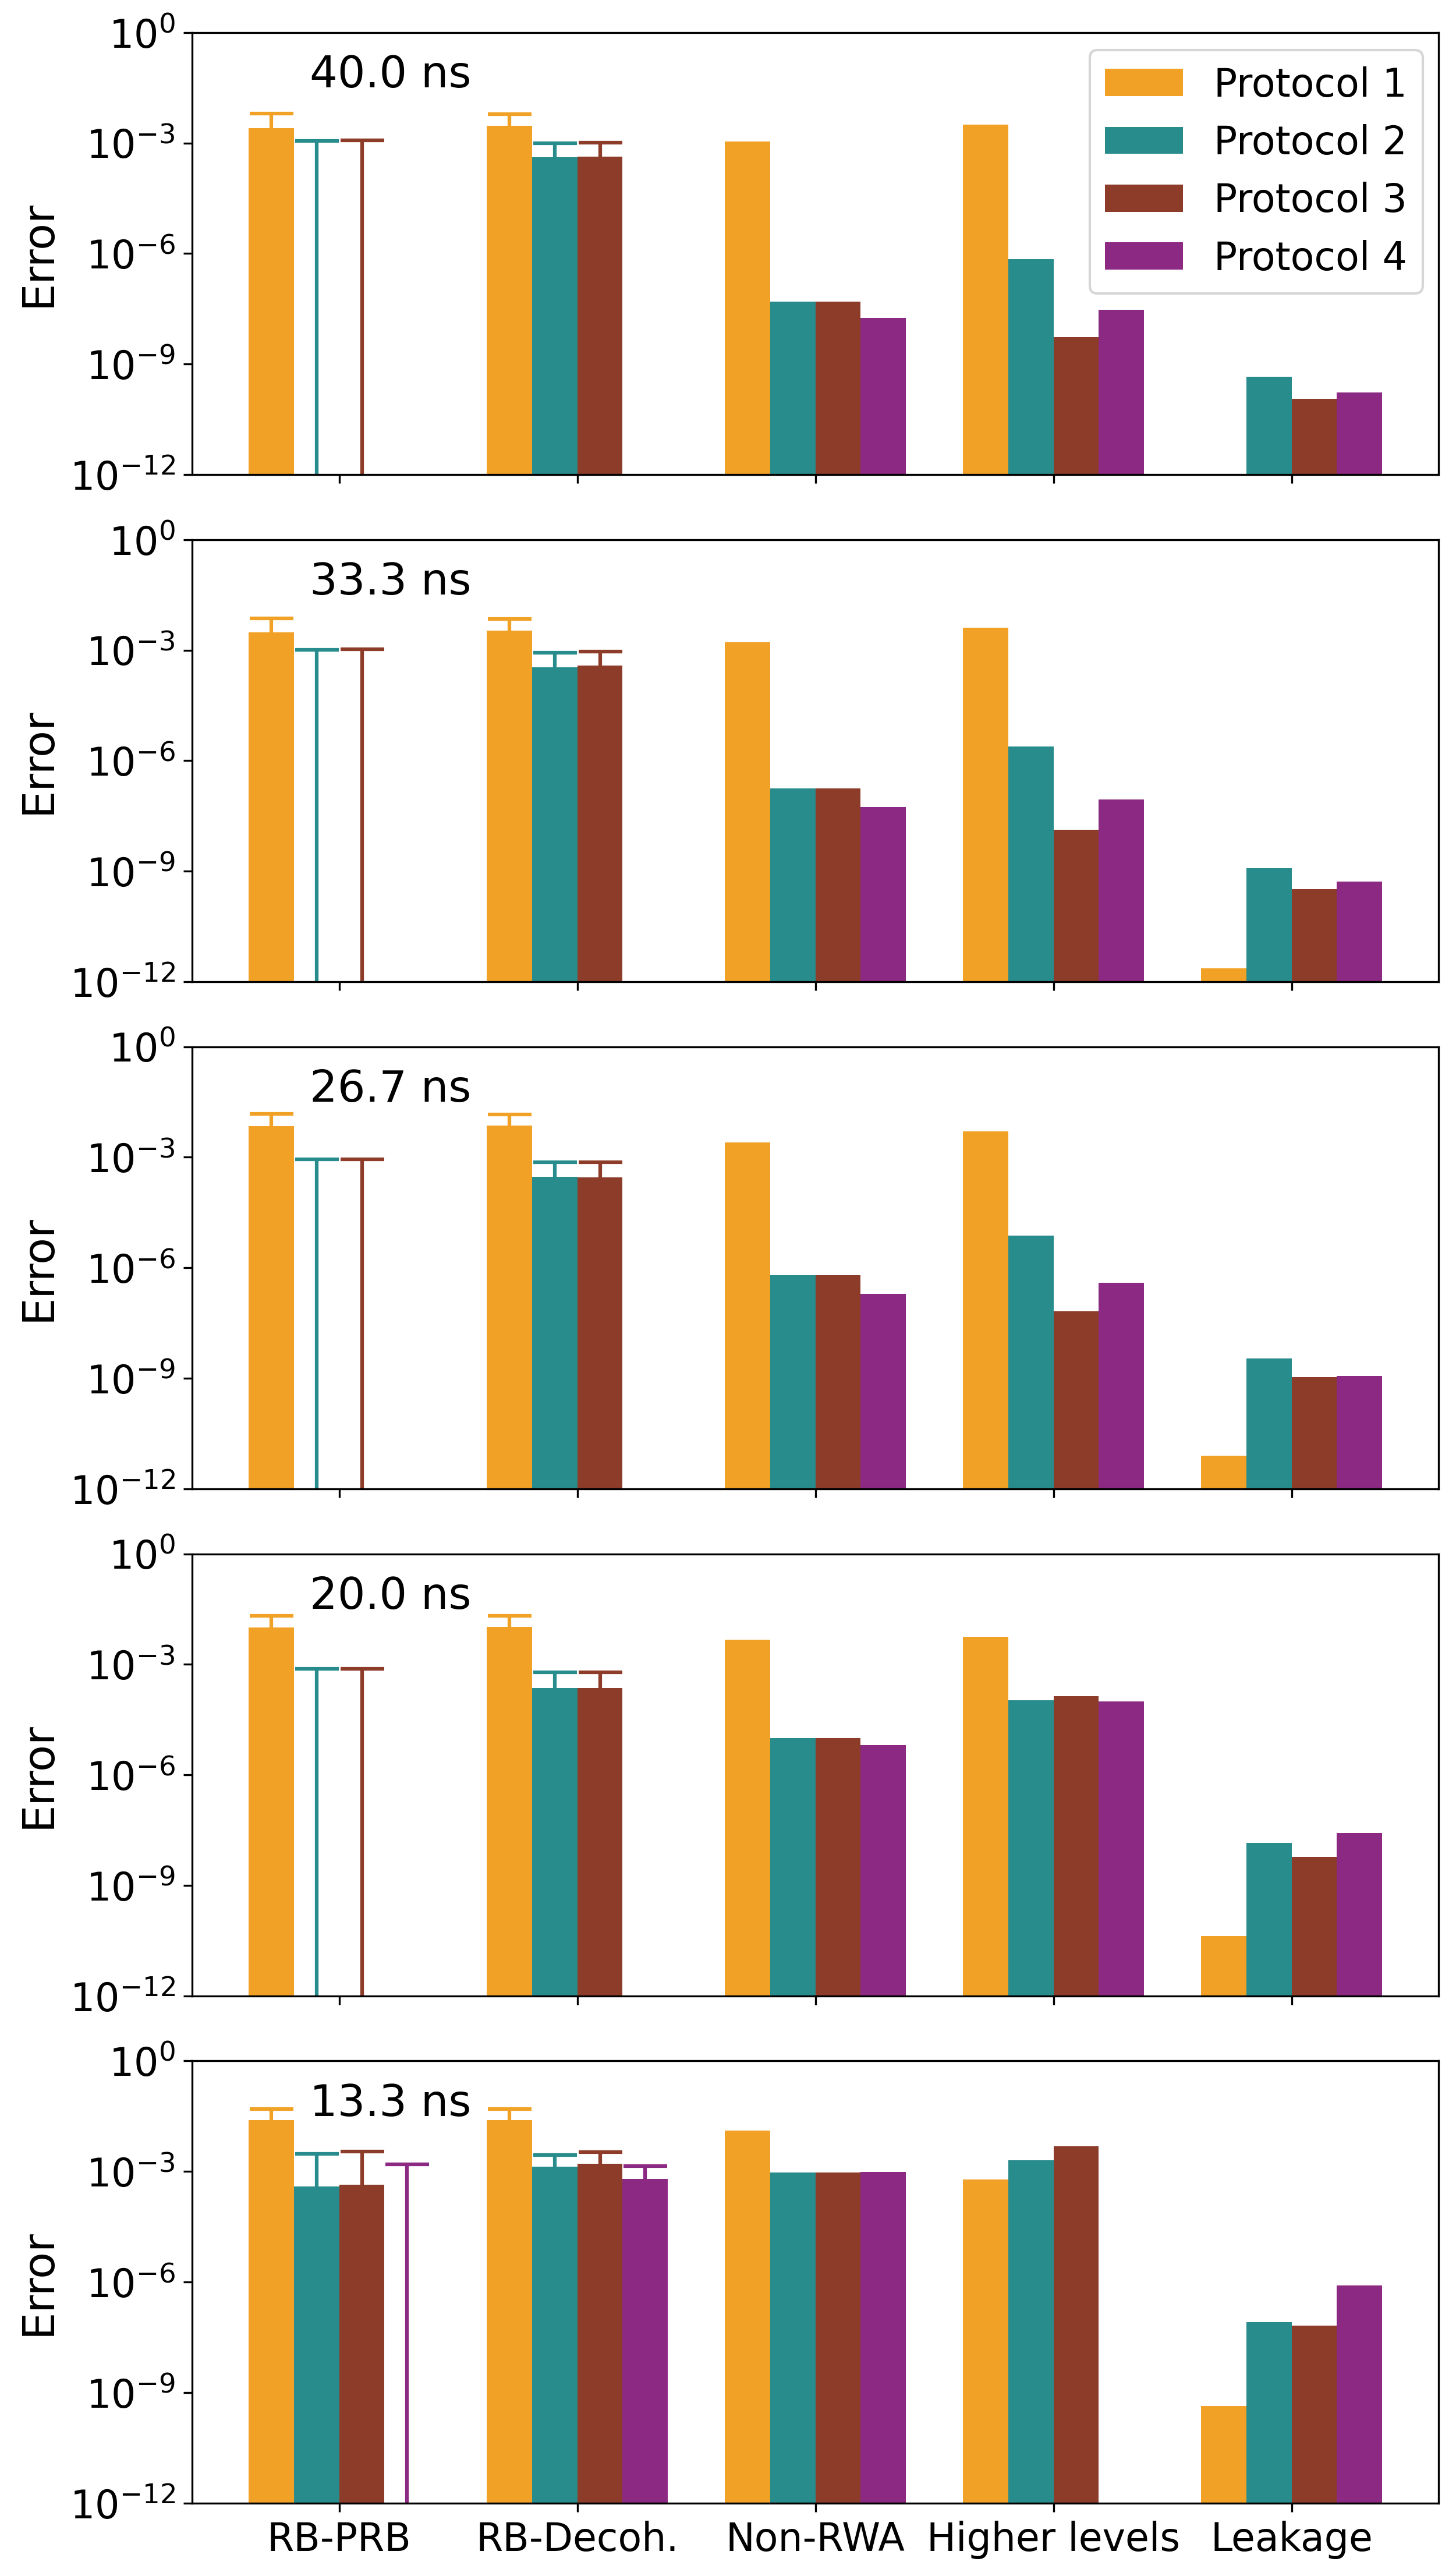

In [ ]:
color_list = ["#f1a226", "#298c8c", "#8C3C29", "#8C2983"]

error_names = ("RB-PRB", "RB-Decoh.", "Non-RWA", "Higher levels", "Leakage")
x = np.arange(len(error_names))
width = 0.19

# fig,ax = plt.subplots(len(tgs), 1, figsize=(8.5,3*len(tgs)), dpi=300)
fig,ax = plt.subplots(len(tgs), 1, figsize=(9,3.2*len(tgs)), dpi=300)

labels = {
    "Protocol 1": "No errors",
    "Protocol 2": "Non-RWA errors",
    "Protocol 3": "All errors",
    "Protocol 4": "Orbit",
}

for idx,tg in enumerate(tgs):
    protocols = {
        "Protocol 1": (errors_p1_measured[idx]-prb_p1_measured[idx], errors_p1_measured[idx]-coherence_limit[idx], error_non_rwa_p1[idx], error_higher_levels_p1[idx], error_leakage_p1[idx]),
        "Protocol 2": (errors_p2_measured[idx]-prb_p2_measured[idx], errors_p2_measured[idx]-coherence_limit[idx], error_non_rwa_p2[idx], error_higher_levels_p2[idx], error_leakage_p2[idx]),
        "Protocol 3": (errors_p3_measured[idx]-prb_p3_measured[idx], errors_p3_measured[idx]-coherence_limit[idx], error_non_rwa_p3[idx], error_higher_levels_p3[idx], error_leakage_p3[idx]),
        "Protocol 4": (errors_p4_measured[idx]-prb_p4_measured[idx], errors_p4_measured[idx]-coherence_limit[idx], error_non_rwa_p4[idx], error_higher_levels_p4[idx], error_leakage_p4[idx]),
    }
    
    multiplier = 0
    for i, (attribute, measurement) in enumerate(protocols.items()):
        offset = width * multiplier
        rects = ax[len(tgs)-idx-1].bar(x + offset, measurement, width, label=labels[attribute], color=color_list[i])
        multiplier += 1

    ax[len(tgs)-idx-1].text(0.16, 0.033, rf"{np.round(tgs[idx]*1e9,1)} ns", fontsize=18)

    # Plot errorbars
    (_, caps1, _) = ax[len(tgs)-idx-1].errorbar(0*width, protocols["Protocol 1"][0], yerr=rb_stds_p1[idx]+prb_stds_p1[idx], capsize=9, color=color_list[0])
    (_, caps2, _) = ax[len(tgs)-idx-1].errorbar(1*width, protocols["Protocol 2"][0], yerr=rb_stds_p2[idx]+prb_stds_p2[idx], capsize=9, color=color_list[1])
    (_, caps3, _) = ax[len(tgs)-idx-1].errorbar(2*width, protocols["Protocol 3"][0], yerr=rb_stds_p3[idx]+prb_stds_p3[idx], capsize=9, color=color_list[2])
    (_, caps4, _) = ax[len(tgs)-idx-1].errorbar(1+0*width, protocols["Protocol 1"][1], yerr=rb_stds_p1[idx], capsize=9, color=color_list[0])
    (_, caps5, _) = ax[len(tgs)-idx-1].errorbar(1+1*width, protocols["Protocol 2"][1], yerr=rb_stds_p2[idx], capsize=9, color=color_list[1])
    (_, caps6, _) = ax[len(tgs)-idx-1].errorbar(1+2*width, protocols["Protocol 3"][1], yerr=rb_stds_p3[idx], capsize=9, color=color_list[2])

    if idx==0:
        (_, caps7, _) = ax[len(tgs)-idx-1].errorbar(3*width, protocols["Protocol 4"][0], yerr=rb_stds_p4+prb_stds_p4, capsize=9, color=color_list[3])
        (_, caps8, _) = ax[len(tgs)-idx-1].errorbar(1+3*width, protocols["Protocol 4"][1], yerr=rb_stds_p4, capsize=9, color=color_list[3])
    else:
        caps7 = caps8 = ()

    for cap in caps1+caps2+caps3+caps3+caps4+caps5+caps6+caps7+caps8:
        cap.set_markeredgewidth(1.5)

for _ax in ax:
    _ax.set_yscale("log")
    _ax.set_ylabel('Error')
    _ax.set_ylim(1e-12, 1)

for _ax in ax[:-1]:
    _ax.set_xticks(x + width*1.5, [""]*len(error_names))

ax[-1].set_xticks(x + width*1.5, error_names)
ax[0].legend(loc=(0.665,0.51), frameon=False, labelspacing=0.4)
fig.tight_layout()
fig.savefig("error-budget.png", dpi=300)

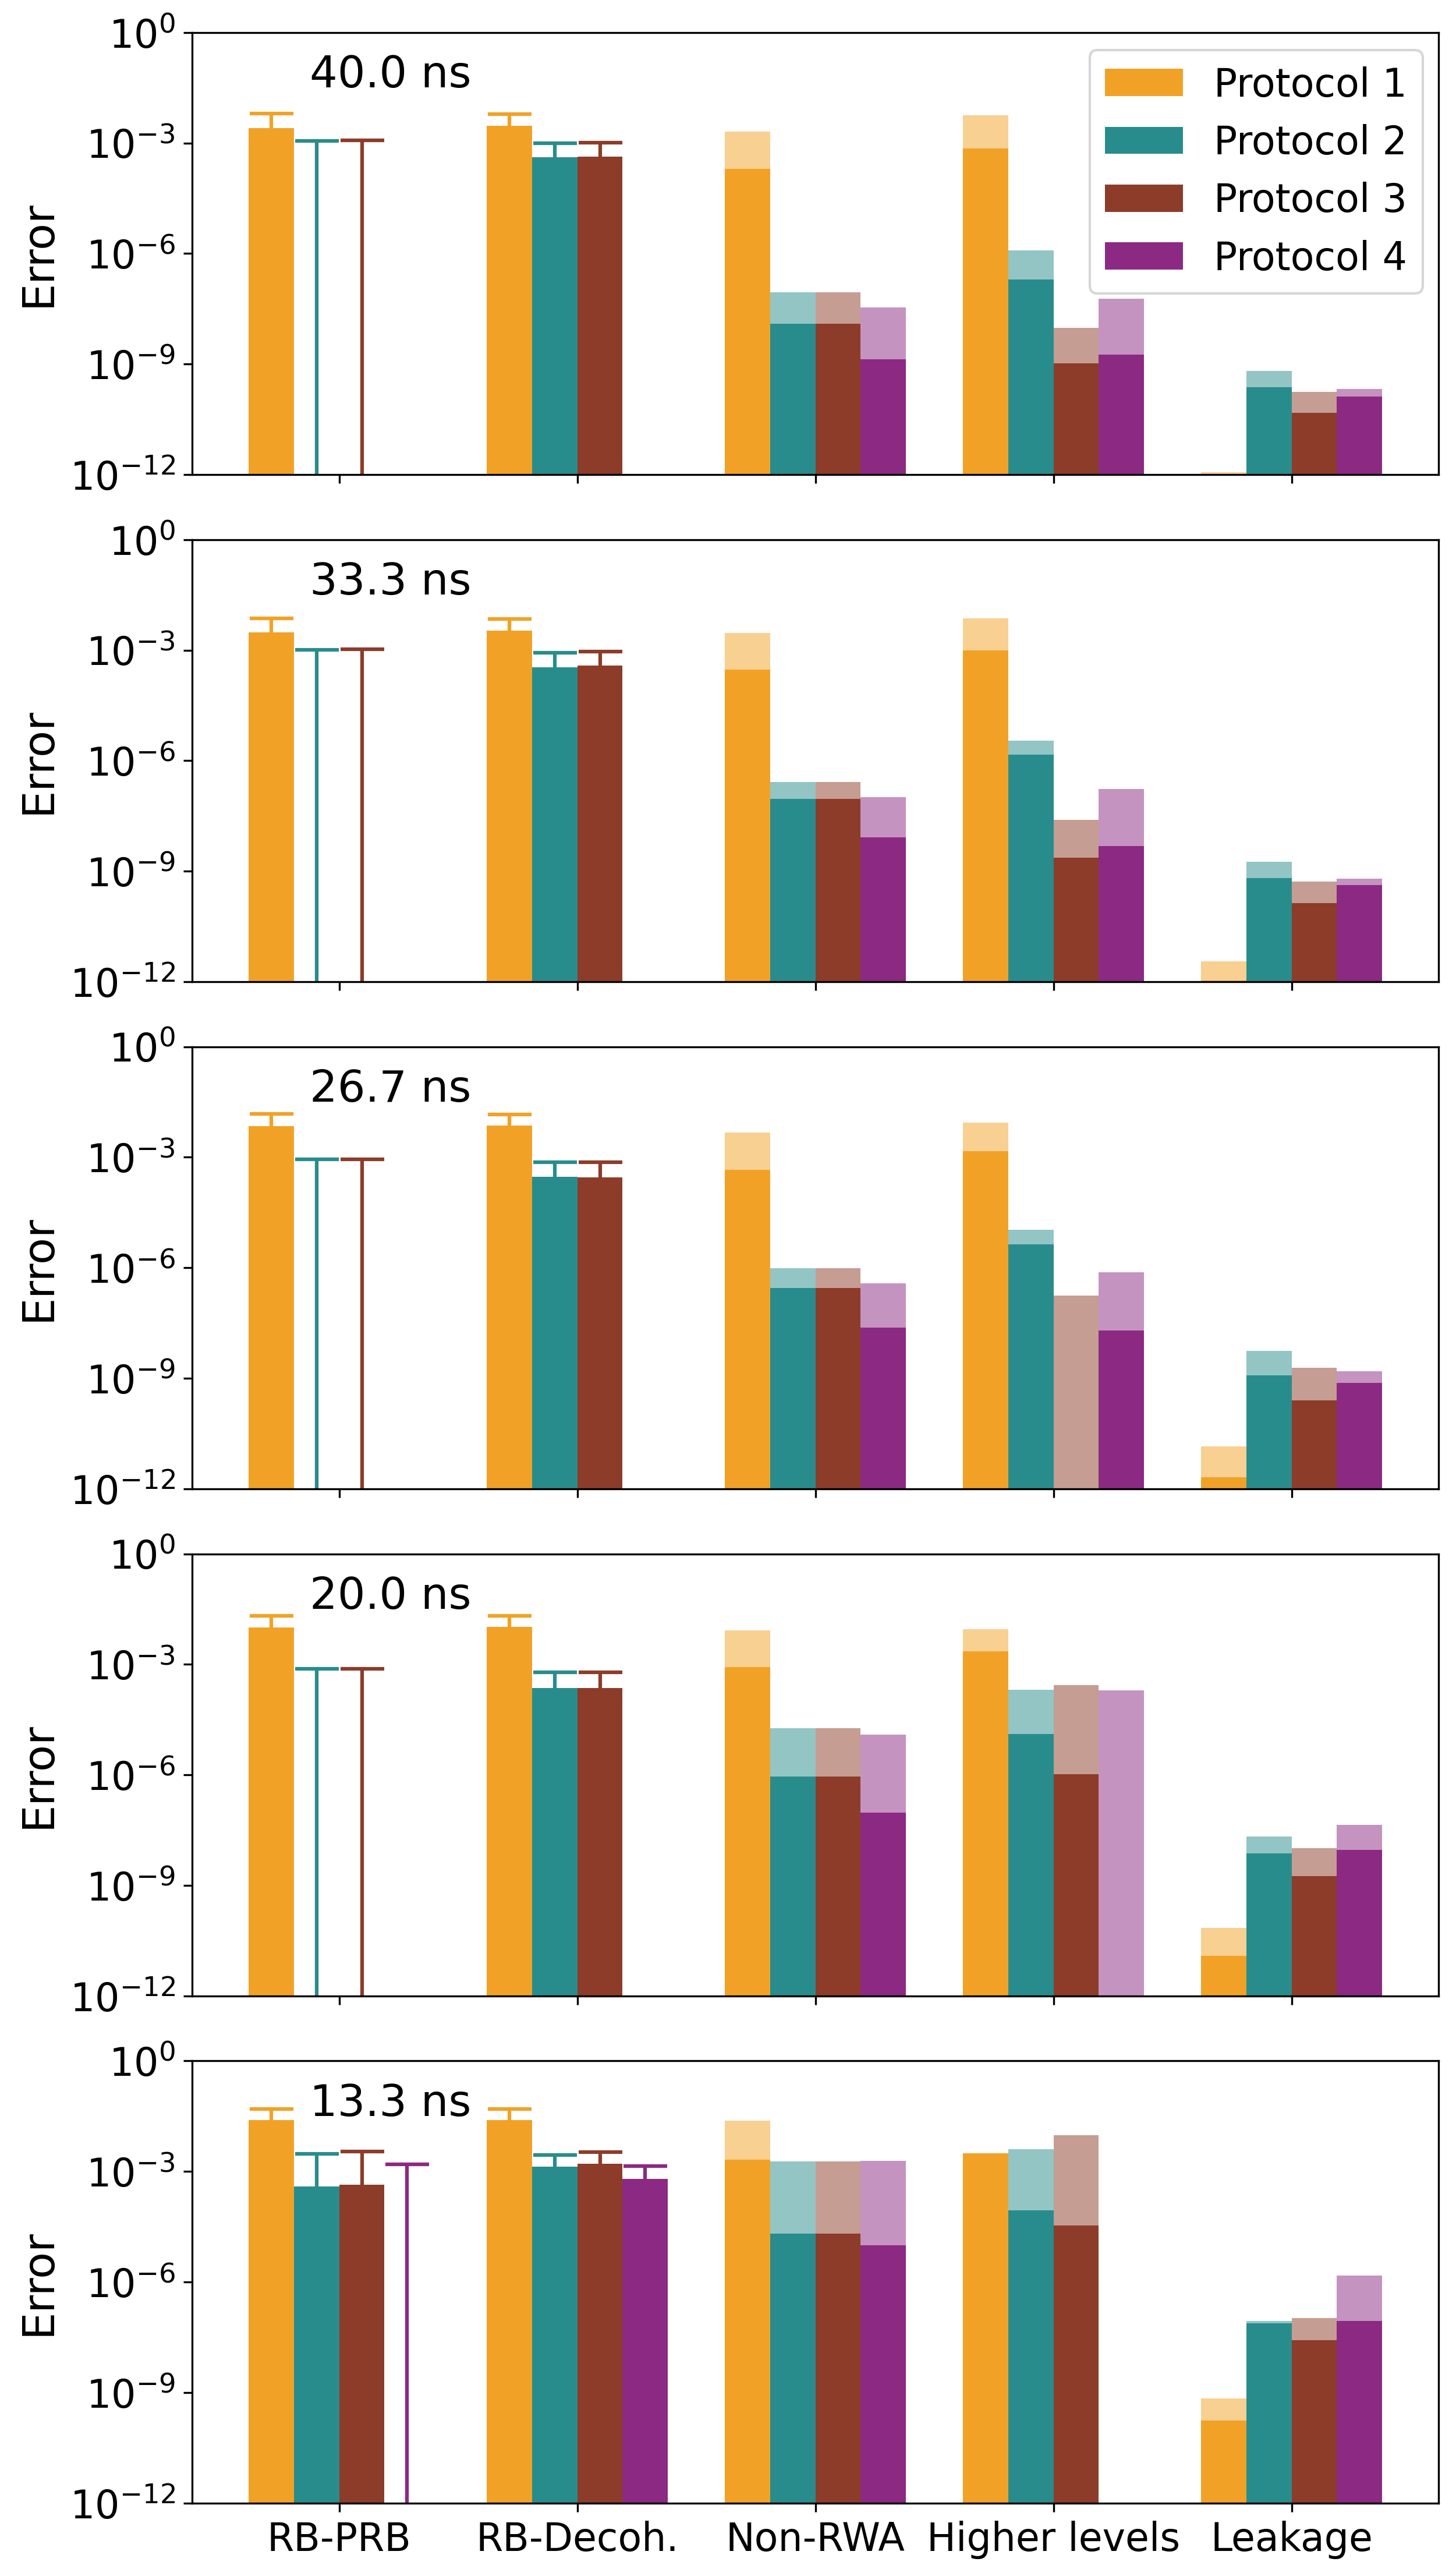

In [41]:
color_list = ["#f1a226", "#298c8c", "#8C3C29", "#8C2983"]

error_names = ("RB-PRB", "RB-Decoh.", "Non-RWA", "Higher levels", "Leakage")
x = np.arange(len(error_names))
width = 0.19

fig,ax = plt.subplots(len(tgs), 1, figsize=(8.5,3*len(tgs)), dpi=300)

for idx,tg in enumerate(tgs):
    protocols_pi2 = {
        "Protocol 1": (errors_p1_measured[idx]-prb_p1_measured[idx], errors_p1_measured[idx]-coherence_limit[idx], results_p1_tls_pi2_error[idx], error_higher_levels_p1_pi2[idx], leakage_p1_pi2[idx]),
        "Protocol 2": (errors_p2_measured[idx]-prb_p2_measured[idx], errors_p2_measured[idx]-coherence_limit[idx], results_p2_tls_pi2_error[idx], error_higher_levels_p2_pi2[idx], leakage_p2_pi2[idx]),
        "Protocol 3": (errors_p3_measured[idx]-prb_p3_measured[idx], errors_p3_measured[idx]-coherence_limit[idx], results_p2_tls_pi2_error[idx], error_higher_levels_p3_pi2[idx], leakage_p3_pi2[idx]),
        "Protocol 4": (errors_p4_measured[idx]-prb_p4_measured[idx], errors_p4_measured[idx]-coherence_limit[idx], results_p4_tls_pi2_error[idx], error_higher_levels_p4_pi2[idx], leakage_p4_pi2[idx]),
    }

    protocols_pi = {
        "Protocol 1": (results_p1_tls_pi_error[idx], error_higher_levels_p1_pi[idx], leakage_p1_pi[idx]),
        "Protocol 2": (results_p2_tls_pi_error[idx], error_higher_levels_p2_pi[idx], leakage_p2_pi[idx]),
        "Protocol 3": (results_p2_tls_pi_error[idx], error_higher_levels_p3_pi[idx], leakage_p3_pi[idx]),
        "Protocol 4": (results_p4_tls_pi_error[idx], error_higher_levels_p4_pi[idx], leakage_p4_pi[idx]),
    }
    
    multiplier = 0
    for i, (attribute, measurement) in enumerate(protocols_pi2.items()):
        offset = width * multiplier
        rects = ax[len(tgs)-idx-1].bar(x[2:] + offset, protocols_pi[attribute], width, color=color_list[i], alpha=0.5)
        rects = ax[len(tgs)-idx-1].bar(x + offset, measurement, width, label=attribute, color=color_list[i])
        multiplier += 1

    ax[len(tgs)-idx-1].text(0.16, 0.033, rf"{np.round(tgs[idx]*1e9,1)} ns", fontsize=18)

    # Plot errorbars
    (_, caps1, _) = ax[len(tgs)-idx-1].errorbar(0*width, protocols_pi2["Protocol 1"][0], yerr=rb_stds_p1[idx]+prb_stds_p1[idx], capsize=9, color=color_list[0])
    (_, caps2, _) = ax[len(tgs)-idx-1].errorbar(1*width, protocols_pi2["Protocol 2"][0], yerr=rb_stds_p2[idx]+prb_stds_p2[idx], capsize=9, color=color_list[1])
    (_, caps3, _) = ax[len(tgs)-idx-1].errorbar(2*width, protocols_pi2["Protocol 3"][0], yerr=rb_stds_p3[idx]+prb_stds_p3[idx], capsize=9, color=color_list[2])
    (_, caps4, _) = ax[len(tgs)-idx-1].errorbar(1+0*width, protocols_pi2["Protocol 1"][1], yerr=rb_stds_p1[idx], capsize=9, color=color_list[0])
    (_, caps5, _) = ax[len(tgs)-idx-1].errorbar(1+1*width, protocols_pi2["Protocol 2"][1], yerr=rb_stds_p2[idx], capsize=9, color=color_list[1])
    (_, caps6, _) = ax[len(tgs)-idx-1].errorbar(1+2*width, protocols_pi2["Protocol 3"][1], yerr=rb_stds_p3[idx], capsize=9, color=color_list[2])

    if idx==0:
        (_, caps7, _) = ax[len(tgs)-idx-1].errorbar(3*width, protocols_pi2["Protocol 4"][0], yerr=rb_stds_p4+prb_stds_p4, capsize=9, color=color_list[3])
        (_, caps8, _) = ax[len(tgs)-idx-1].errorbar(1+3*width, protocols_pi2["Protocol 4"][1], yerr=rb_stds_p4, capsize=9, color=color_list[3])
    else:
        caps7 = caps8 = ()

    for cap in caps1+caps2+caps3+caps3+caps4+caps5+caps6+caps7+caps8:
        cap.set_markeredgewidth(1.5)

for _ax in ax:
    _ax.set_yscale("log")
    _ax.set_ylabel('Error')
    _ax.set_ylim(1e-12, 1)

for _ax in ax[:-1]:
    _ax.set_xticks(x + width*1.5, [""]*len(error_names))

ax[-1].set_xticks(x + width*1.5, error_names)
ax[0].legend(loc=(0.72,0.41))
fig.tight_layout()
fig.savefig("error-budget.png", dpi=300)

# Heatmaps

In [14]:
ppps = np.linspace(-0.5, 0.5, 31)
detunings = np.linspace(-5, 5, 31)
# Interp objs for heatmaps
xx_interp = interp1d(ppps, np.arange(len(ppps)))
yy_interp = interp1d(detunings, len(detunings) - np.arange(len(detunings)))

In [6]:
# 40 ns
data_folders = get_data_folders(base_dir+"20241202/", start=104205, stop=151614)
# Fitted ppp and detuning (fit made using the code below)
fit_ppp      = -0.00396
fit_detuning = -0.0198

In [364]:
# 33.333 ns
data_folders = get_data_folders(base_dir+"20241202/", start=151632, stop=201258)
# Fitted ppp and detuning (fit made using the code below)
fit_ppp      = -0.00673
fit_detuning =  0.0393

In [374]:
# 26.666 ns
data_folders = np.concatenate((
    get_data_folders(base_dir+"20241202/", start=201318, stop=235959),
    get_data_folders(base_dir+"20241203/", start=0, stop=12638),
))
# Fitted ppp and detuning (fit made using the code below)
fit_ppp      = -0.0181
fit_detuning =  0.0436

In [384]:
# 20 ns
data_folders = get_data_folders(base_dir+"20241203/", start=12657, stop=64412)
# Fitted ppp and detuning (fit made using the code below)
fit_ppp      = -0.0534
fit_detuning = -0.0014

In [436]:
# 13.333 ns
data_folders = get_data_folders(base_dir+"20241203/", start=64434, stop=123439)
fit_ppp      = -0.19712912
fit_detuning = 0.02940773

In [51]:
# 40 ns
data_folders = get_data_folders(base_dir+"20241214/", start=91854, stop=113013)
# Fitted ppp and detuning (fit made using the code below)
fit_ppp      = -0.00396
fit_detuning = -0.0198

# Remove index of failed experiment
for i,data_folder in enumerate(data_folders):
    if data_folder.split("/")[-1].split("-")[1]=="110837":
        del data_folders[i+1]
        del data_folders[i]
        break

In [ ]:
# 33.333 ns
data_folders = get_data_folders(base_dir+"20241214/", start=113022, stop=135738)
# Fitted ppp and detuning (fit made using the code below)
fit_ppp      = -0.00396
fit_detuning = -0.0198

In [499]:
# 26.666 ns
data_folders = get_data_folders(base_dir+"20241214/", start=135748, stop=164220)
# Fitted ppp and detuning (fit made using the code below)
fit_ppp      = -0.11062705
fit_detuning = 0.05008554

In [78]:
# 20 ns
data_folders = get_data_folders(base_dir+"20241214/", start=164230, stop=193539)
# Fitted ppp and detuning (fit made using the code below)
fit_ppp      = -0.00396
fit_detuning = -0.0198

In [83]:
# 13.333 ns
data_folders = get_data_folders(base_dir+"20241214/", start=193550, stop=223419)
# Fitted ppp and detuning (fit made using the code below)
fit_ppp      = -0.00396
fit_detuning = -0.0198

In [ ]:
results_contrast_pi = np.zeros(len(detunings)*len(ppps))
results_contrast_pi2 = np.zeros(len(detunings)*len(ppps))
f01s = np.zeros(len(detunings)*len(ppps))

for i,data_folder in enumerate(data_folders):
    if i%2!=0:
        continue

    with h5py.File(data_folder+"/dataset.hdf5", "r") as f:
        counts_0 = np.array(list(f["counts_0"]))

    n = len(counts_0)//2
    results_contrast_pi[i//2] = np.max(counts_0[:n]) - np.min(counts_0[:n])
    results_contrast_pi2[i//2] = np.max(counts_0[n:]) - np.min(counts_0[n:])

results_pi  = results_contrast_pi.reshape((len(detunings), len(ppps)))
results_pi2 = results_contrast_pi2.reshape((len(detunings), len(ppps)))

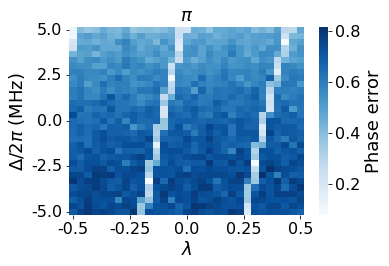

In [492]:
fig,ax = fig_prepare("ppp", "Detuning")
ax.grid(False)
ax = sns.heatmap(np.flip(results_pi,axis=0), xticklabels=ppps, yticklabels=np.round(np.flip(detunings),2), cmap="Blues", cbar_kws={"label": "Phase error"}, ax=ax)

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(detunings)), np.flip(detunings))

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(detunings)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

ax.set_title(r"$\pi$", fontsize=18)
fig.set_size_inches(5.5,3.8)

fig.tight_layout()
fig.savefig("3D-contrast-pi.png", dpi=200)

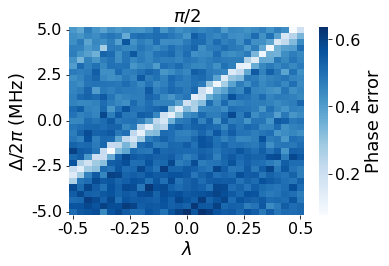

In [501]:
fig,ax = fig_prepare("ppp", "Detuning")
ax.grid(False)
ax = sns.heatmap(np.flip(results_pi2,axis=0), xticklabels=ppps, yticklabels=np.round(np.flip(detunings),2), cmap="Blues", cbar_kws={"label": "Phase error"}, ax=ax)

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(detunings)), np.flip(detunings))

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(detunings)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

ax.set_title(r"$\pi/2$", fontsize=18)
fig.set_size_inches(5.5,3.8)

fig.tight_layout()
fig.savefig("3D-contrast-pi2.png", dpi=200)

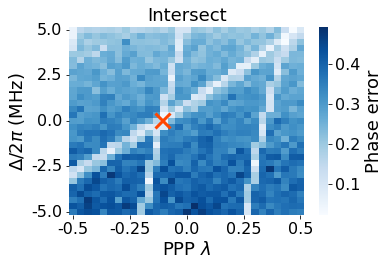

In [502]:
fig,ax = fig_prepare("ppp", "Detuning")
ax.grid(False)
ax = sns.heatmap(np.flip(results_pi*results_pi2,axis=0), xticklabels=ppps, yticklabels=np.round(np.flip(detunings),2), cmap="Blues", cbar_kws={"label": "Phase error"}, ax=ax)

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(detunings)), np.flip(detunings))

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(detunings)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"PPP $\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

ax.plot(xx_interp(fit_ppp)+0.5, yy_interp(fit_detuning)-0.5, marker="x", color=colors["red"], markersize=15, markeredgewidth=3)

ax.set_title(r"Intersect", fontsize=18)
fig.set_size_inches(5.5,3.8)

fig.tight_layout()
fig.savefig("3D-intersect.png", dpi=200)

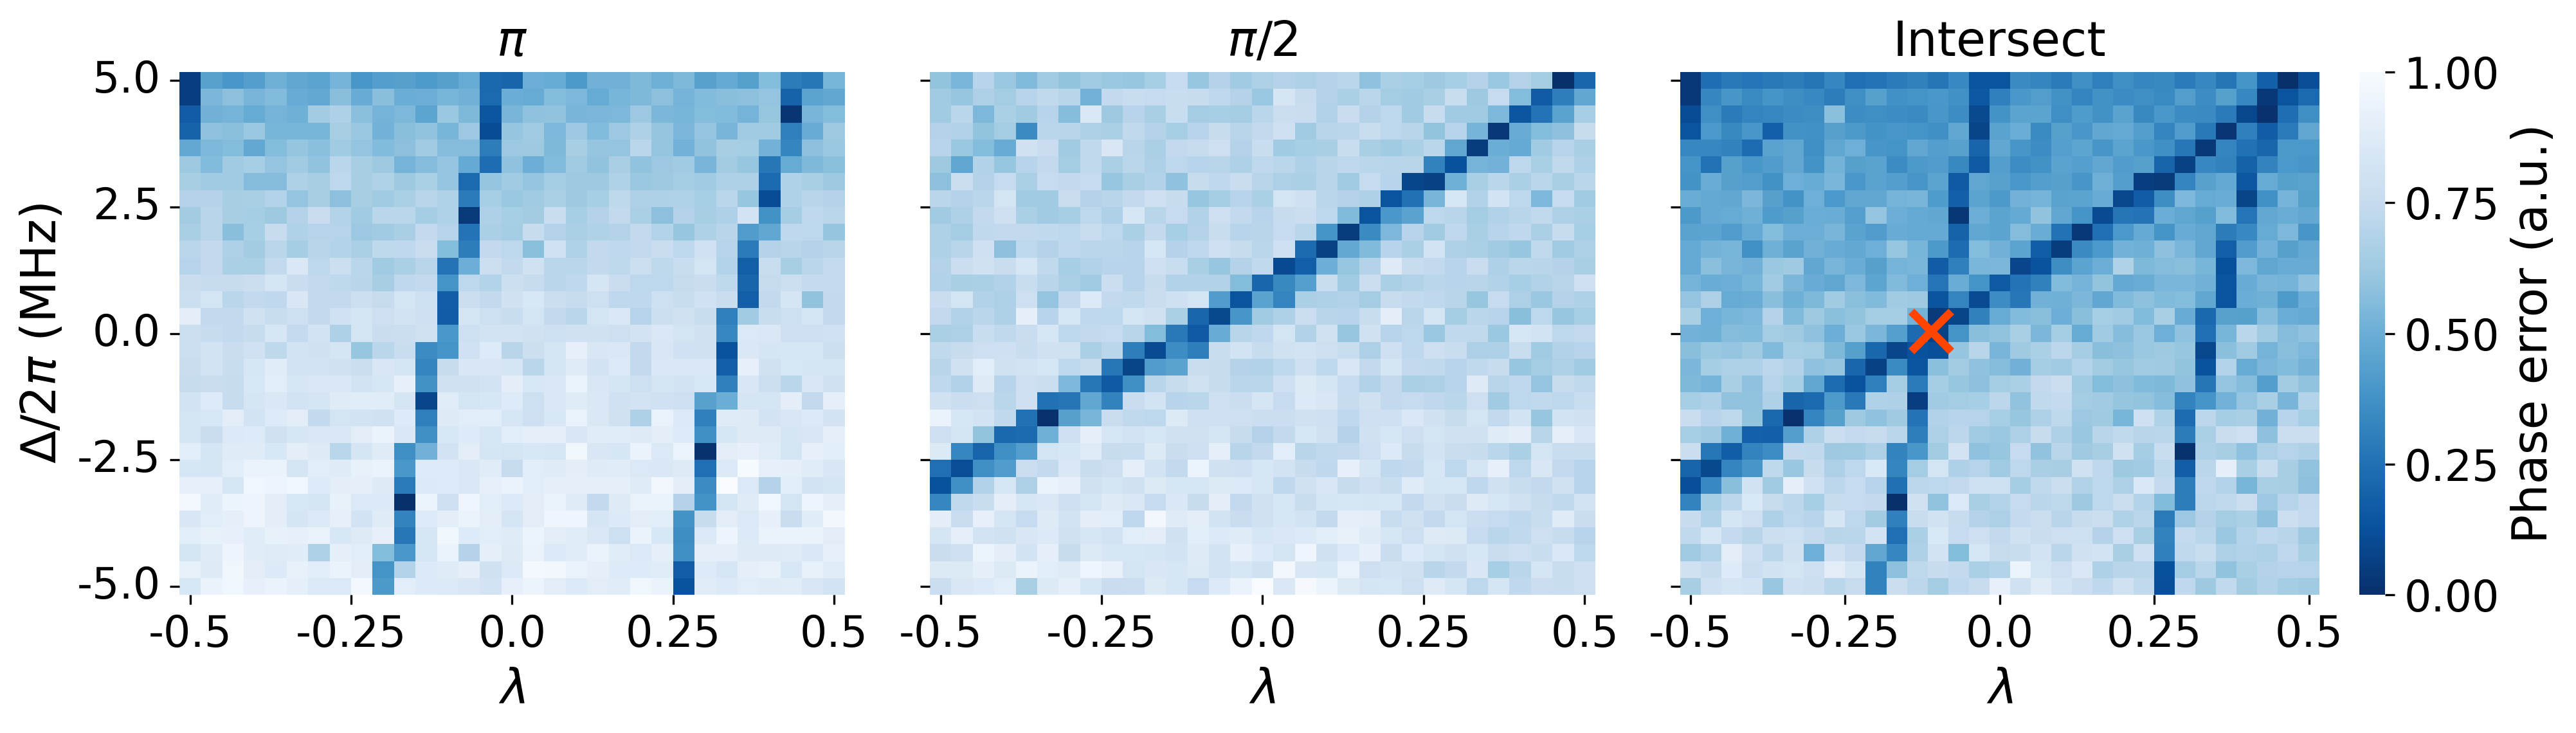

In [513]:
data_phase_errors_1 = (results_pi-np.min(results_pi))/(np.max(results_pi)-np.min(results_pi))
data_phase_errors_2 = (results_pi2-np.min(results_pi2))/(np.max(results_pi2)-np.min(results_pi2))
data_phase_errors_3 = data_phase_errors_1*data_phase_errors_2

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(detunings)), np.flip(detunings))
idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(detunings)-1,5)
norm = Normalize(vmin=0, vmax=1)

fig,ax = plt.subplots(1, 3, figsize=(13.5,3.9), dpi=300, width_ratios=[1,1,1.2])

for _ax in ax:
    _ax.grid(False)


## Plot figure (a)
ax[0] = sns.heatmap(np.flip(data_phase_errors_1,axis=0), 
                    xticklabels=ppps, 
                    yticklabels=np.round(np.flip(detunings),2), 
                    cmap="Blues_r", 
                    norm=norm,
                    cbar=False, 
                    ax=ax[0])

ax[0].set_xticks([0.5+i for i in idx])
ax[0].set_yticks([0.5+i for i in idx2])
ax[0].set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax[0].set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax[0].set_yticklabels(np.round(y_interp(idx2), 2))

ax[0].set_title(r"$\pi$", fontsize=18)

## Plot figure (b)
ax[1] = sns.heatmap(np.flip(data_phase_errors_2,axis=0), 
                    xticklabels=ppps, 
                    yticklabels=np.round(np.flip(detunings),2), 
                    cmap="Blues_r", 
                    norm=norm,
                    cbar=False, 
                    ax=ax[1])

ax[1].set_xticks([0.5+i for i in idx])
ax[1].set_yticks([0.5+i for i in idx2])
ax[1].set(xlabel=r"$\lambda$", ylabel=r"")
ax[1].set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax[1].set_yticklabels([""]*len(idx2))

ax[1].set_title(r"$\pi/2$", fontsize=18)

## Plot figure (c)
ax[2] = sns.heatmap(np.flip(data_phase_errors_3,axis=0), 
                    xticklabels=ppps, 
                    yticklabels=np.round(np.flip(detunings),2), 
                    cmap="Blues_r", 
                    norm=norm,
                    cbar_kws={"label": "Phase error (a.u.)",
                              "ticks":[0, 0.25, 0.5, 0.75, 1]},
                    ax=ax[2])

ax[2].set_xticks([0.5+i for i in idx])
ax[2].set_yticks([0.5+i for i in idx2])
ax[2].set(xlabel=r"$\lambda$", ylabel=r"")
ax[2].set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax[2].set_yticklabels([""]*len(idx2))

ax[2].plot(xx_interp(fit_ppp)+0.5, yy_interp(fit_detuning)-0.5, marker="x", color=colors["red"], markersize=15, markeredgewidth=3)

ax[2].set_title(r"Intersect", fontsize=18)

plt.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

fig.savefig("figures-presentations/experimental-heatmaps.png", dpi=200)

In [494]:
results_fit_pi2_ppp   = []
results_fit_pi2_delta = []
for i in range(results_pi2.shape[0]):
    if np.min(results_pi2[i,:])>0.25:
        continue

    results_fit_pi2_delta.append(detunings[i])
    results_fit_pi2_ppp.append(ppps[np.argmin(results_pi2[i,:])])

results_fit_pi_ppp   = []
results_fit_pi_delta = []
# Change idx0 and idx1 to limit range for pi scan
idx0 = np.argmin(np.square(ppps+0.4))
idx1 = np.argmin(np.square(ppps-0.1))
for i in range(results_pi.shape[0]):
    if np.min(results_pi[i,idx0:idx1])>0.4:
        continue

    results_fit_pi_delta.append(detunings[i])
    results_fit_pi_ppp.append(ppps[idx0+np.argmin(results_pi[i,idx0:idx1])])

In [495]:
z = np.polyfit(results_fit_pi2_ppp, results_fit_pi2_delta, 2)
p_pi2 = np.poly1d(z)
xx_pi2 = np.linspace(np.min(results_fit_pi2_ppp), np.max(results_fit_pi2_ppp), 101)

z = np.polyfit(results_fit_pi_ppp, results_fit_pi_delta, 2)
p_pi = np.poly1d(z)
xx_pi = np.linspace(np.min(results_fit_pi_ppp), np.max(results_fit_pi_ppp), 101)

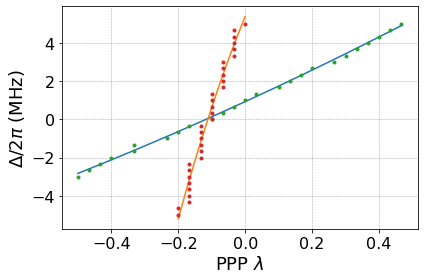

In [496]:
fig,ax = fig_prepare(r"PPP $\lambda$", r"$\Delta/2\pi$ (MHz)")
ax.plot(xx_pi2, p_pi2(xx_pi2))
ax.plot(xx_pi, p_pi(xx_pi))
ax.plot(results_fit_pi2_ppp, results_fit_pi2_delta, linestyle="", marker=".")
ax.plot(results_fit_pi_ppp, results_fit_pi_delta, linestyle="", marker=".")
fig.tight_layout()
fig.savefig("fit-linecuts.png", dpi=200)

In [497]:
def fun(x):
    return np.square(p_pi(x)-p_pi2(x))

# Potentially change x0 and bounds
res = minimize(fun, x0=[-0.2], bounds=((-0.4,0),))

In [498]:
print(res["x"], p_pi(res["x"]), p_pi2(res["x"]))

[-0.11062705] [0.05008554] [0.05008569]


# Heatmap final figures

In [20]:
extended_data = load_dataset("20250124-131553", folder_name="extended-data", json_fname="extended_data")

In [21]:
tgs = [13.3, 20, 26.7, 33.3, 40]

data_folders = [
    # 13 ns
    get_data_folders(base_dir+"20241214/", start=193550, stop=223419),
    # 20 ns
    get_data_folders(base_dir+"20241214/", start=164230, stop=193539),
    # 26.666 ns
    get_data_folders(base_dir+"20241214/", start=135748, stop=164220),
    # 33.333 ns
    get_data_folders(base_dir+"20241214/", start=113022, stop=135738),
    # 40 ns
    ## requires trickery
]

data_folders_40ns = get_data_folders(base_dir+"20241214/", start=91854, stop=113013)

# Remove index of failed experiment
# (This experiment crashed and was automatically rerun)
for i,data_folder in enumerate(data_folders_40ns):
    if data_folder.split("/")[-1].split("-")[1]=="110837":
        del data_folders_40ns[i+1]
        del data_folders_40ns[i]
        break

data_folders.append(data_folders_40ns)


# Setpoints
ppps = np.linspace(-0.5, 0.5, 31)
detunings = np.linspace(-5, 5, 31)

In [22]:
xx_interp = interp1d(ppps, np.arange(len(ppps)))
yy_interp = interp1d(detunings, len(detunings) - np.arange(len(detunings)))

# Define values for axis ticks
x_vals = np.array([-0.5, 0, 0.5])
y_vals = np.array([-5, 0, 5])

min1, max1 = 0, 1
cmap = "Blues_r"

In [23]:
# Obtain experimental data
exp_results_pi = np.zeros((len(tgs), len(detunings), len(ppps)))
exp_results_pi2 = np.zeros((len(tgs), len(detunings), len(ppps)))

for idx,tg in enumerate(tgs):
    # Obtain measured contrasts for tg
    results_contrast_pi = np.zeros(len(detunings)*len(ppps))
    results_contrast_pi2 = np.zeros(len(detunings)*len(ppps))
    f01s = np.zeros(len(detunings)*len(ppps))

    for i,data_folder in enumerate(data_folders[idx]):
        if i%2!=0:
            continue

        with h5py.File(data_folder+"/dataset.hdf5", "r") as f:
            counts_0 = np.array(list(f["counts_0"]))

        n = len(counts_0)//2
        results_contrast_pi[i//2] = np.max(counts_0[:n]) - np.min(counts_0[:n])
        results_contrast_pi2[i//2] = np.max(counts_0[n:]) - np.min(counts_0[n:])

    exp_results_pi[idx,:,:]  = results_contrast_pi.reshape((len(detunings), len(ppps)))
    exp_results_pi2[idx,:,:] = results_contrast_pi2.reshape((len(detunings), len(ppps)))

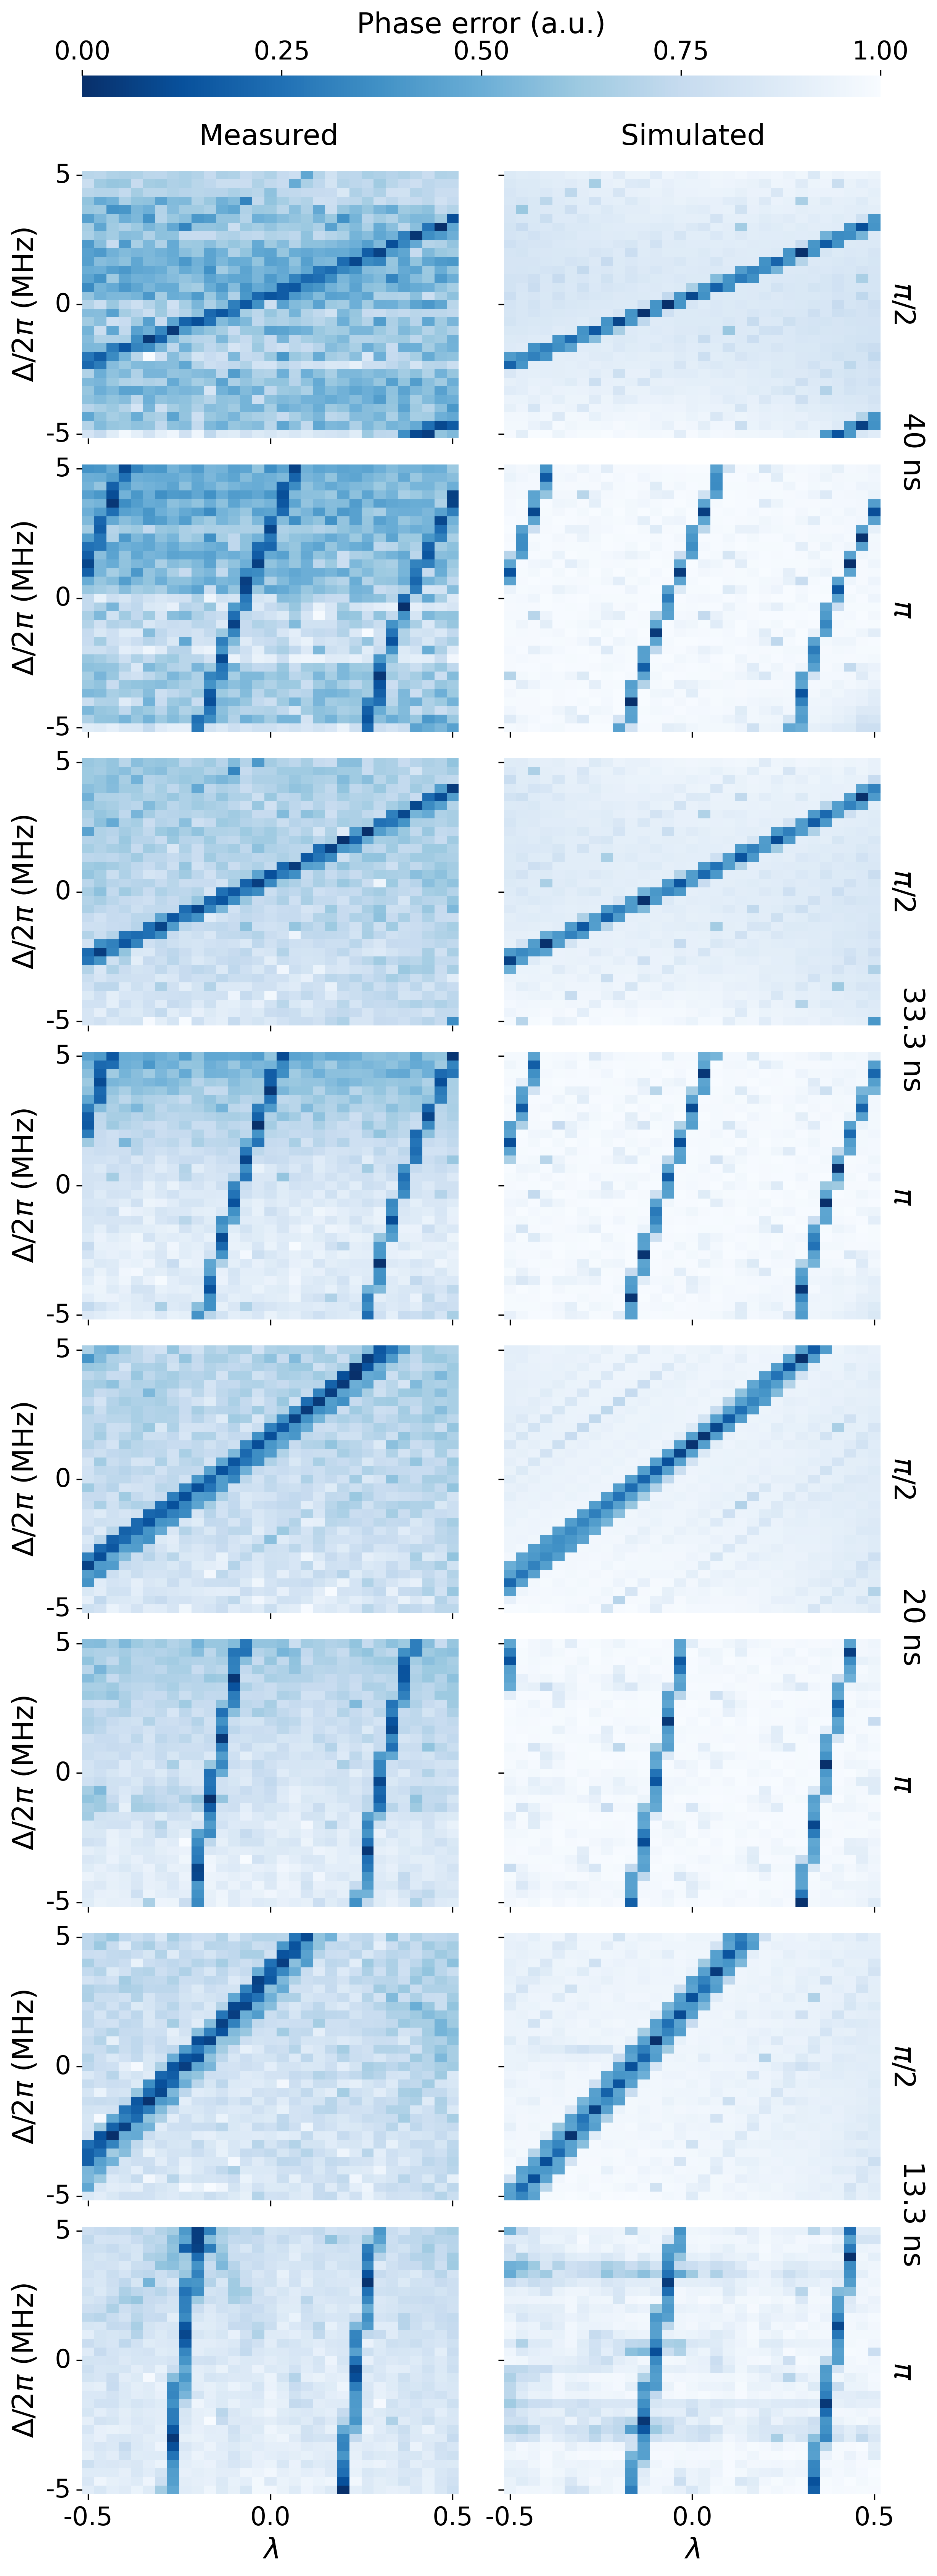

In [ ]:
fig = plt.figure(figsize=(9,3.4*8), dpi=300)
gs = plt.GridSpec(10,2, figure=fig, height_ratios=[0.08,0.08,1,1,1,1,1,1,1,1], wspace=0.12, hspace=0.12)

# Actual axis with data
axs = np.empty((10,2), dtype=object)
for i in range(8):
    axs[i,0] = fig.add_subplot(gs[2+i,0])
    axs[i,1] = fig.add_subplot(gs[2+i,1])

# Axis for heatmap
ax11 = fig.add_subplot(gs[0,:])
# Axis for text
ax12 = fig.add_subplot(gs[1,0])
ax13 = fig.add_subplot(gs[1,1])

ax12.set_axis_off()
ax13.set_axis_off()
ax12.text(0.31, 0, r"Measured", fontsize=18)
ax13.text(0.31, 0, r"Simulated", fontsize=18)

_tgs = [40, 33.3, 20, 13.3]
_exp_results_pi = np.delete(exp_results_pi, 2, axis=0)
_exp_results_pi2 = np.delete(exp_results_pi2, 2, axis=0)
_didx = [4,3,1,0]
for idx,tg in enumerate(_tgs):
    didx = len(_tgs)-idx-1
    # Get measured results
    results_pi  = _exp_results_pi[didx,:,:]
    results_pi2 = _exp_results_pi2[didx,:,:]

    # Get numerical results
    numerical_pi = extended_data["heatmaps_processed"][f"y{2*_didx[idx]}"]
    numerical_pi2 = extended_data["heatmaps_processed"][f"y{2*_didx[idx]+1}"]

    # Normalize all setpoints
    results_pi = (results_pi - np.min(results_pi)) / (np.max(results_pi) - np.min(results_pi))
    results_pi2 = (results_pi2 - np.min(results_pi2)) / (np.max(results_pi2) - np.min(results_pi2))
    numerical_pi = (numerical_pi - np.min(numerical_pi)) / (np.max(numerical_pi) - np.min(numerical_pi))
    numerical_pi2 = (numerical_pi2 - np.min(numerical_pi2)) / (np.max(numerical_pi2) - np.min(numerical_pi2))

    ## Plot data
    # Plot experimental pi/2
    if idx==0:
        # Only figure with scalebar
        axs[2*idx,0] = sns.heatmap(data=np.flip(results_pi2, axis=0), 
                                   xticklabels=ppps, 
                                   yticklabels=np.flip(detunings), 
                                   cmap=cmap, 
                                   ax=axs[2*idx,0],
                                   norm=Normalize(vmin=min1, vmax=max1),
                                   cbar_ax=ax11,
                                   cbar_kws={"label": "Phase error (a.u.)",
                                             "ticks":[0, 0.25, 0.5, 0.75, 1],
                                             "orientation": "horizontal",
                                             "location": "top"})
    else:
        axs[2*idx,0] = sns.heatmap(data=np.flip(results_pi2, axis=0), 
                                   xticklabels=ppps, 
                                   yticklabels=np.flip(detunings), 
                                   cmap=cmap, 
                                   ax=axs[2*idx,0],
                                   norm=Normalize(vmin=min1, vmax=max1),
                                   cbar=False)

    # Plot numerical pi/2
    axs[2*idx,1] = sns.heatmap(data=numerical_pi2.T, 
                               xticklabels=ppps, 
                               yticklabels=np.flip(detunings), 
                               cmap=cmap, 
                               ax=axs[2*idx,1],
                               norm=Normalize(vmin=min1, vmax=max1),
                               cbar=False)

    # Plot experimental pi
    axs[2*idx+1,0] = sns.heatmap(data=np.flip(results_pi, axis=0), 
                                 xticklabels=ppps, 
                                 yticklabels=np.flip(detunings), 
                                 cmap=cmap, 
                                 ax=axs[2*idx+1,0],
                                 norm=Normalize(vmin=min1, vmax=max1),
                                 cbar=False)

    # Plot numerical pi
    axs[2*idx+1,1] = sns.heatmap(data=numerical_pi.T, 
                                 xticklabels=ppps, 
                                 yticklabels=np.flip(detunings), 
                                 cmap=cmap, 
                                 ax=axs[2*idx+1,1],
                                 norm=Normalize(vmin=min1, vmax=max1),
                                 cbar=False)

    ## Plot labels and ticks
    # Left top
    axs[2*idx,0].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                            labels=[""]*len(x_vals))
    axs[2*idx,0].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                            labels=y_vals)
    axs[2*idx,0].set(xlabel=r"", ylabel=r"$\Delta/2\pi$ (MHz)")

    # Right top
    axs[2*idx,1].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                            labels=[""]*len(x_vals))
    axs[2*idx,1].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                            labels=[""]*len(y_vals))
    axs[2*idx,1].set(xlabel=r"", ylabel=r"")

    # Left bottom
    if idx==len(_tgs)-1:
        axs[2*idx+1,0].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                                  labels=x_vals,
                                  rotation=0)
        axs[2*idx+1,0].set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
    else:
        axs[2*idx+1,0].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                                  labels=[""]*len(x_vals))
        axs[2*idx+1,0].set(xlabel=r"", ylabel=r"$\Delta/2\pi$ (MHz)")
    axs[2*idx+1,0].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                              labels=y_vals)
    

    # Right bottom
    if idx==len(_tgs)-1:
        axs[2*idx+1,1].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                                  labels=x_vals,
                                  rotation=0)
        axs[2*idx+1,1].set(xlabel=r"$\lambda$", ylabel=r"")
    else:
        axs[2*idx+1,1].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                                  labels=[""]*len(x_vals))
        axs[2*idx+1,1].set(xlabel=r"", ylabel=r"")
    axs[2*idx+1,1].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                              labels=[""]*len(y_vals))

    # Plot gate duration on right axis
    _ax = axs[2*idx,1].twinx()
    _ax.grid(False)
    _ax.set_yticks([])
    # _ax.set_xticks([])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    _ax.spines['bottom'].set_visible(False)
    _ax.spines['left'].set_visible(False)
    _ax.set_ylabel(f"{tg} ns", rotation=270)
    _ax.yaxis.set_label_coords(1.12, -0.05)
    _ax.text(1.02, 0.45, r"$\pi/2$", rotation=270, fontsize=18, transform=_ax.transAxes)
    _ax.text(1.02, -0.65, r"$\pi$", rotation=270, fontsize=18, transform=_ax.transAxes)

fig.savefig("all-heatmaps.png", dpi=300)

# Final experimental figure

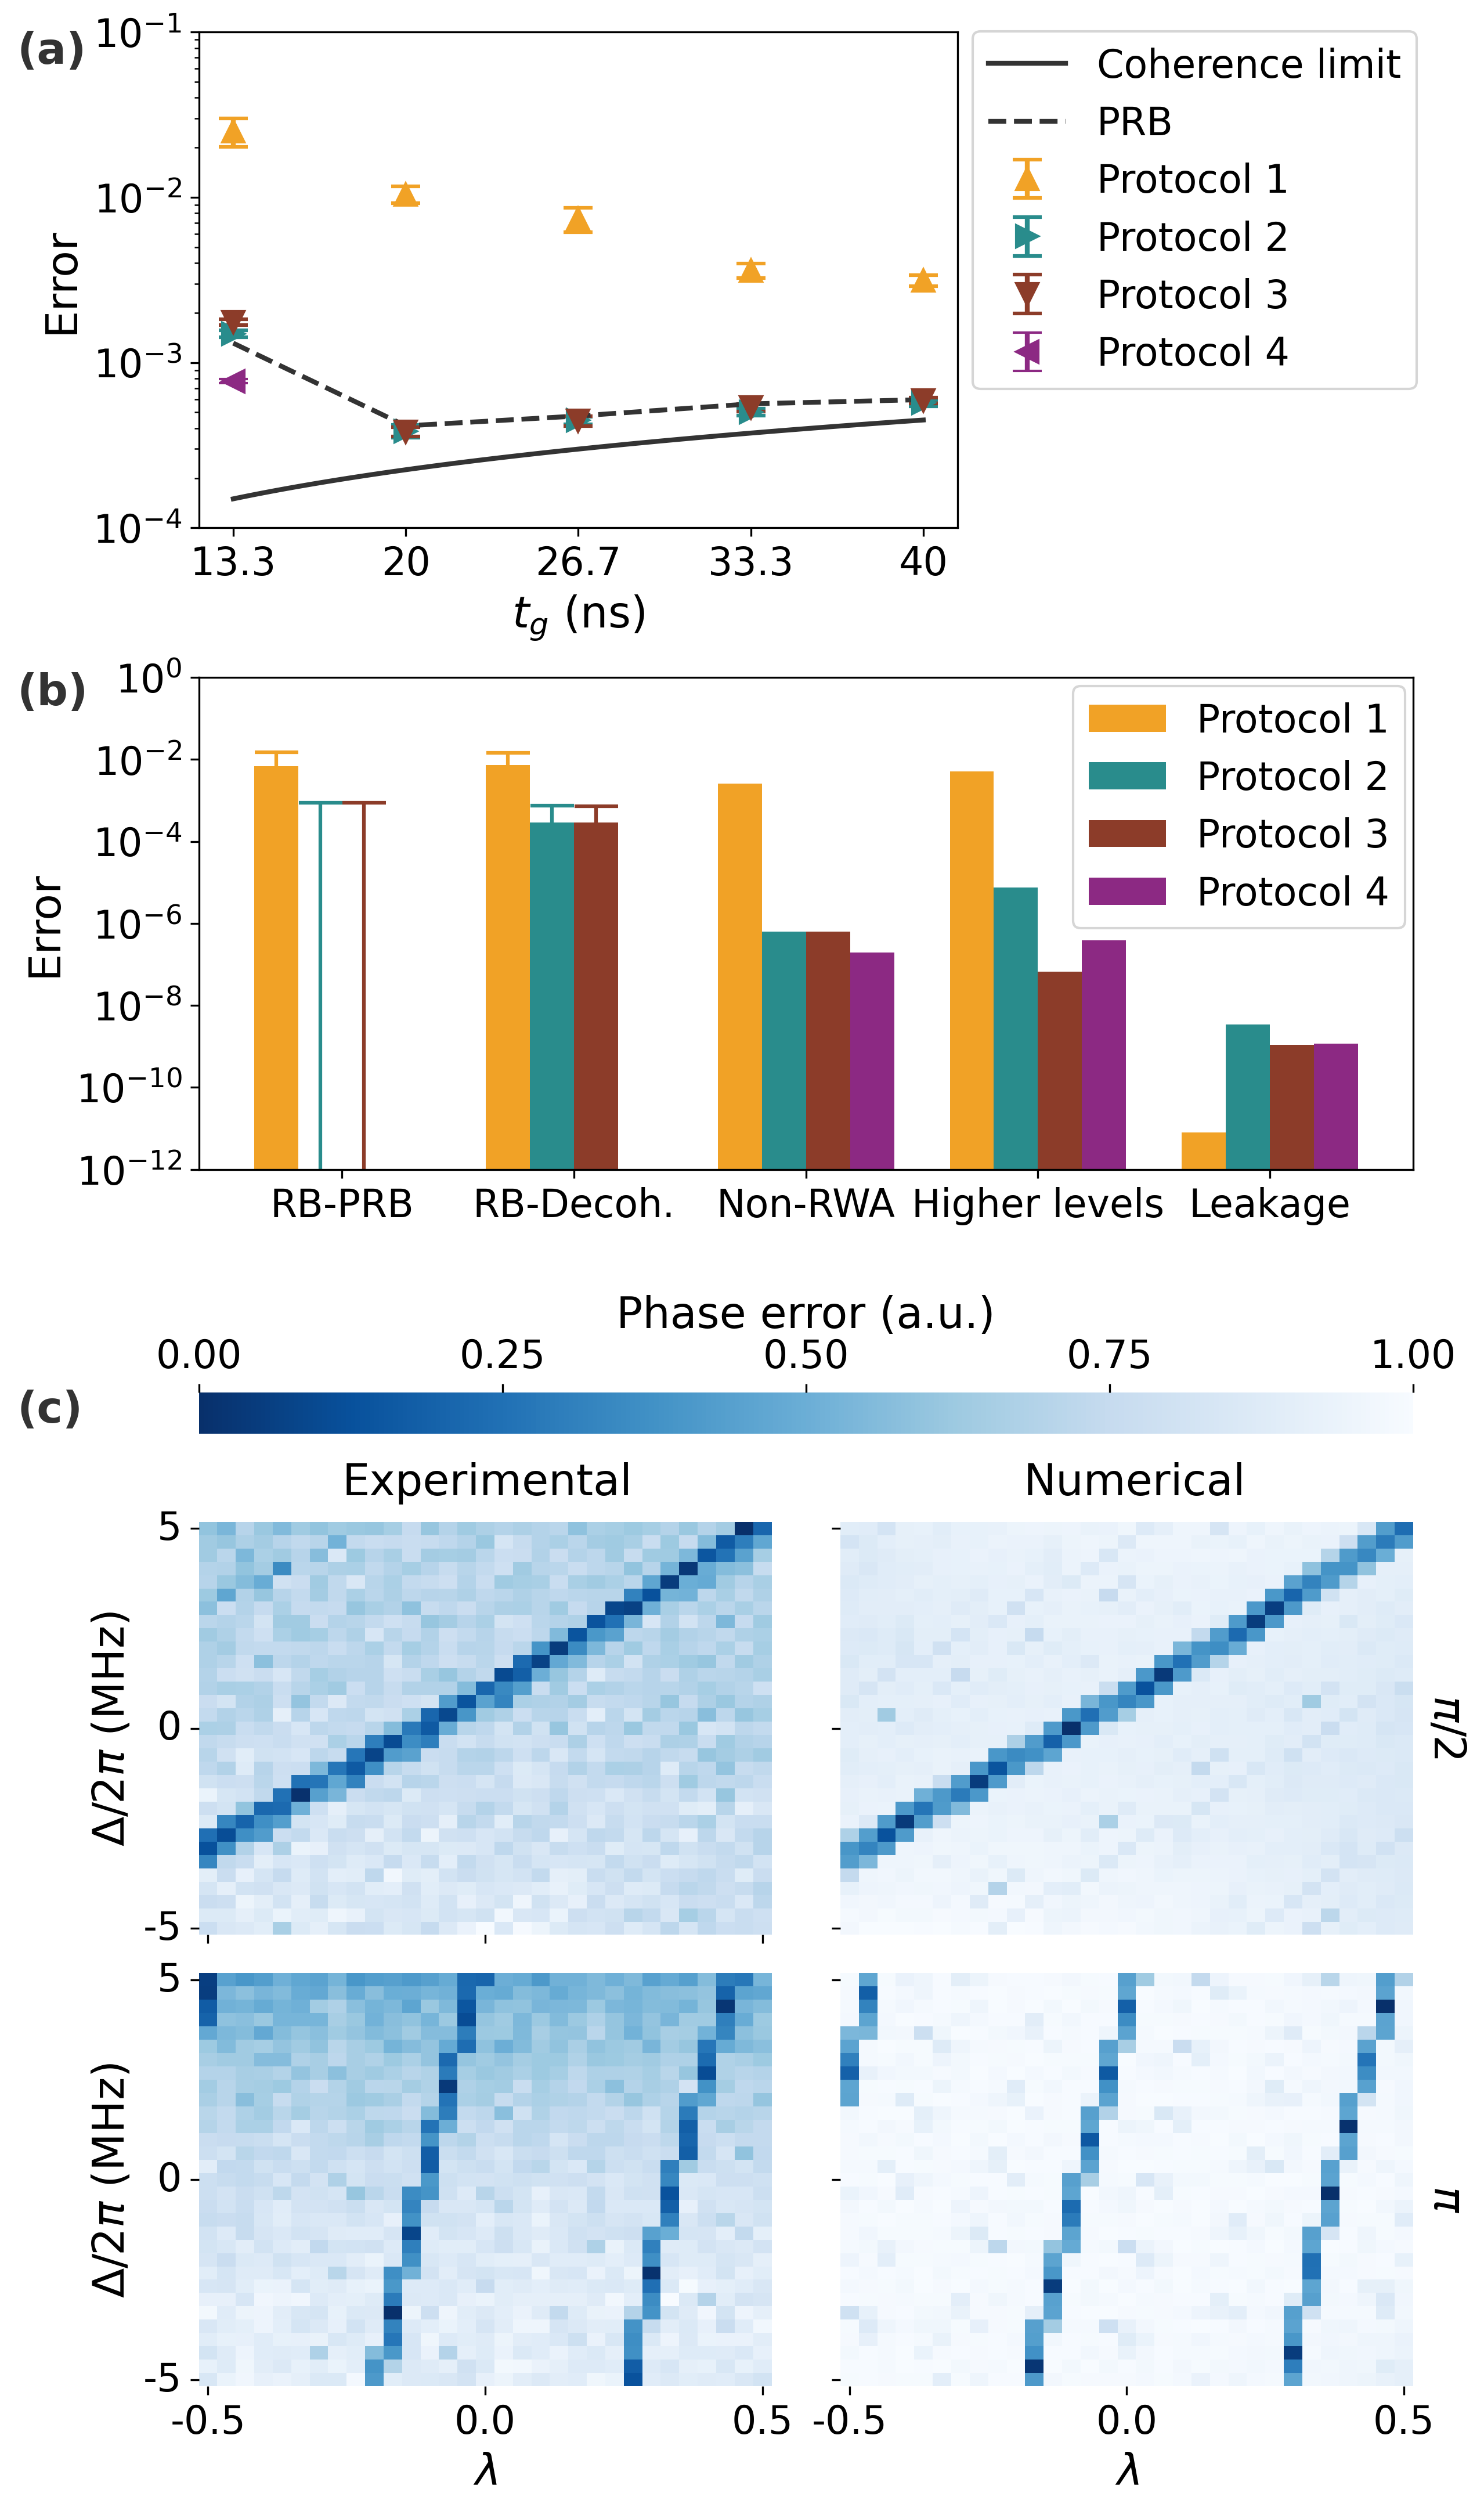

In [ ]:
## Init figure and axes
fig = plt.figure(figsize=(10,16.5), dpi=300)
gs = plt.GridSpec(6,2, figure=fig, height_ratios=[0.252,0.25,0.03, 0.02,0.19,0.19], wspace=0.12, hspace=0.12)

# Ax for RB data figure
ax0 = fig.add_subplot(gs[0,:])
# Ax for error budget
ax1 = fig.add_subplot(gs[1,:])
# Ax for heatmap
ax2 = fig.add_subplot(gs[2,:])
# Ax for text
ax3 = fig.add_subplot(gs[3,0])
ax4 = fig.add_subplot(gs[3,1])
# Ax for heatmaps
axs = np.empty((2,2), dtype=object)
for i in range(2):
    axs[i,0] = fig.add_subplot(gs[4+i,0])
    axs[i,1] = fig.add_subplot(gs[4+i,1])

## Add text labels for heatmaps
ax3.set_axis_off()
ax4.set_axis_off()
ax3.text(0.25, 0, r"Experimental", fontsize=18)
ax4.text(0.32, 0, r"Numerical", fontsize=18)

## Plot figure (a)
results_tgs = figure_data[0]["x0"]
results_errors = figure_data[0]["y0"]
results_stds = figure_data[0]["y1"]

xx = 1e-9 * np.linspace(np.min(results_tgs), np.max(results_tgs), 101)
coherence_limit = 0.5 + 1/6 * np.exp(-xx/75e-6) + 1/3*np.exp(-xx/37e-6)
coherence_limit = (1-coherence_limit)

results_purity_p3 = results_errors[21:31:2]

color_list = ["#f1a226", "#298c8c", "#8C3C29", "#8C2983"]
ax0.set_yscale("log")
(_, caps1, _) = ax0.errorbar(results_tgs, results_errors[:10:2], yerr=results_stds[:10:2], linestyle="", marker="^", markersize=9, capsize=6, linewidth=2, color=color_list[0], label="No errors")
(_, caps2, _) = ax0.errorbar(results_tgs, results_errors[10:20:2], yerr=results_stds[10:20:2], linestyle="", marker=">", markersize=9, capsize=6, linewidth=2, color=color_list[1], label="Non-RWA errors")
(_, caps3, _) = ax0.errorbar(results_tgs, results_errors[20:30:2], yerr=results_stds[20:30:2], linestyle="", marker="v", markersize=9, capsize=6, linewidth=2, color=color_list[2], label="All errors")
ax0.errorbar(results_tgs[-1], results_errors[-2], yerr=results_stds[-2], linestyle="", marker="<", markersize=9, capsize=6, linewidth=2, color=color_list[3], label="Orbit")
ax0.plot(xx*1e9, coherence_limit, linewidth=2, color="#333", label="Coherence limit")
ax0.plot(results_tgs, results_purity_p3, linewidth=2, color="#333", linestyle="--", label="PRB")

for cap in caps1+caps2+caps3:
    cap.set_markeredgewidth(1.5)

ax0.set_xticks(ticks=np.flip(results_tgs), 
               labels=[13.3, 20, 26.7, 33.3, 40])
ax0.legend(loc=[0.1,0.75], frameon=False, ncol=3, labelspacing=0.4, columnspacing=0.9)
ax0.set_yticks([1e-4,1e-3,1e-2,1e-1])
ax0.set_ylabel("Error")
ax0.set_xlabel(r"$t_g$ (ns)")

## Plot figure (b)
error_names = ("RB-PRB", "RB-Decoh.", "Non-RWA", "Higher levels", "Leakage")
labels = {
    "Protocol 1": "No errors",
    "Protocol 2": "Non-RWA errors",
    "Protocol 3": "All errors",
    "Protocol 4": "Orbit",
}
x = np.arange(len(error_names))
width = 0.19
idx = 2
protocols = {
    "Protocol 1": (errors_p1_measured[idx]-prb_p1_measured[idx], errors_p1_measured[idx]-coherence_limit[idx], error_non_rwa_p1[idx], error_higher_levels_p1[idx], error_leakage_p1[idx]),
    "Protocol 2": (errors_p2_measured[idx]-prb_p2_measured[idx], errors_p2_measured[idx]-coherence_limit[idx], error_non_rwa_p2[idx], error_higher_levels_p2[idx], error_leakage_p2[idx]),
    "Protocol 3": (errors_p3_measured[idx]-prb_p3_measured[idx], errors_p3_measured[idx]-coherence_limit[idx], error_non_rwa_p3[idx], error_higher_levels_p3[idx], error_leakage_p3[idx]),
    "Protocol 4": (errors_p4_measured[idx]-prb_p4_measured[idx], errors_p4_measured[idx]-coherence_limit[idx], error_non_rwa_p4[idx], error_higher_levels_p4[idx], error_leakage_p4[idx]),
}

# Plot bars
multiplier = 0
for i, (attribute, measurement) in enumerate(protocols.items()):
    offset = width * multiplier
    rects = ax1.bar(x + offset, measurement, width, label=labels[attribute], color=color_list[i])    
    multiplier += 1

# Plot errorbars
rb_stds_p1 = results_errors[:10:2]
prb_stds_p1 = results_errors[1:11:2]
rb_stds_p2 = results_errors[10:20:2]
prb_stds_p2 = results_errors[11:21:2]
rb_stds_p3 = results_errors[20:30:2]
prb_stds_p3 = results_errors[21:31:2]
(_, caps1, _) = ax1.errorbar(0*width, protocols["Protocol 1"][0], yerr=rb_stds_p1[idx]+prb_stds_p1[idx], capsize=9, color=color_list[0])
(_, caps2, _) = ax1.errorbar(1*width, protocols["Protocol 2"][0], yerr=rb_stds_p2[idx]+prb_stds_p2[idx], capsize=9, color=color_list[1])
(_, caps3, _) = ax1.errorbar(2*width, protocols["Protocol 3"][0], yerr=rb_stds_p3[idx]+prb_stds_p3[idx], capsize=9, color=color_list[2])
(_, caps4, _) = ax1.errorbar(1+0*width, protocols["Protocol 1"][1], yerr=rb_stds_p1[idx], capsize=9, color=color_list[0])
(_, caps5, _) = ax1.errorbar(1+1*width, protocols["Protocol 2"][1], yerr=rb_stds_p2[idx], capsize=9, color=color_list[1])
(_, caps6, _) = ax1.errorbar(1+2*width, protocols["Protocol 3"][1], yerr=rb_stds_p3[idx], capsize=9, color=color_list[2])

for cap in caps1+caps2+caps3+caps3+caps4+caps5+caps6:
    cap.set_markeredgewidth(1.5)

ax1.set_yscale("log")
ax1.set_ylabel('Error')
ax1.set_ylim(1e-12, 1)
ax1.set_xticks(x + width*1.5, error_names)
ax1.legend(loc=(0.67,0.555), frameon=False, labelspacing=0.4)

## Plot figure (c)
didx = 2
# Get measured results
results_pi  = exp_results_pi[didx,:,:]
results_pi2 = exp_results_pi2[didx,:,:]

# Get numerical results
numerical_pi = extended_data["heatmaps_processed"][f"y{2*didx}"]
numerical_pi2 = extended_data["heatmaps_processed"][f"y{2*didx+1}"]

# Normalize all setpoints
results_pi = (results_pi - np.min(results_pi)) / (np.max(results_pi) - np.min(results_pi))
results_pi2 = (results_pi2 - np.min(results_pi2)) / (np.max(results_pi2) - np.min(results_pi2))
numerical_pi = (numerical_pi - np.min(numerical_pi)) / (np.max(numerical_pi) - np.min(numerical_pi))
numerical_pi2 = (numerical_pi2 - np.min(numerical_pi2)) / (np.max(numerical_pi2) - np.min(numerical_pi2))

## Plot data
# Plot experimental pi/2
axs[0,0] = sns.heatmap(data=np.flip(results_pi2, axis=0), 
                       xticklabels=ppps, 
                       yticklabels=np.flip(detunings), 
                       cmap=cmap, 
                       ax=axs[0,0],
                       norm=Normalize(vmin=min1, vmax=max1),
                       cbar_ax=ax2,
                       cbar_kws={"label": "Phase error (a.u.)",
                                 "ticks":[0, 0.25, 0.5, 0.75, 1],
                                 "orientation": "horizontal",
                                 "location": "top"})

# Plot numerical pi/2
axs[0,1] = sns.heatmap(data=numerical_pi2.T, 
                       xticklabels=ppps, 
                       yticklabels=np.flip(detunings), 
                       cmap=cmap, 
                       ax=axs[0,1],
                       norm=Normalize(vmin=min1, vmax=max1),
                       cbar=False)

# Plot experimental pi
axs[1,0] = sns.heatmap(data=np.flip(results_pi, axis=0), 
                       xticklabels=ppps, 
                       yticklabels=np.flip(detunings), 
                       cmap=cmap, 
                       ax=axs[1,0],
                       norm=Normalize(vmin=min1, vmax=max1),
                       cbar=False)

# Plot numerical pi
axs[1,1] = sns.heatmap(data=numerical_pi.T, 
                       xticklabels=ppps, 
                       yticklabels=np.flip(detunings), 
                       cmap=cmap, 
                       ax=axs[1,1],
                       norm=Normalize(vmin=min1, vmax=max1),
                       cbar=False)

## Plot labels and ticks
# Left top
axs[0,0].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                    labels=[""]*len(x_vals))
axs[0,0].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                    labels=y_vals)
axs[0,0].set(xlabel=r"", ylabel=r"$\Delta/2\pi$ (MHz)")

# Right top
axs[0,1].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                    labels=[""]*len(x_vals))
axs[0,1].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                    labels=[""]*len(y_vals))
axs[0,1].set(xlabel=r"", ylabel=r"")

# Left bottom
axs[1,0].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                    labels=x_vals,
                    rotation=0)
axs[1,0].set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
axs[1,0].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                    labels=y_vals)


# Right bottom
axs[1,1].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                    labels=x_vals,
                    rotation=0)
axs[1,1].set(xlabel=r"$\lambda$", ylabel=r"")
axs[1,1].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                    labels=[""]*len(y_vals))

# Plot gate duration on right axis
_ax = axs[0,1].twinx()
_ax.grid(False)
_ax.set_yticks([])
_ax.spines['top'].set_visible(False)
_ax.spines['right'].set_visible(False)
_ax.spines['bottom'].set_visible(False)
_ax.spines['left'].set_visible(False)
_ax.text(1.02, 0.45, r"$\pi/2$", rotation=270, fontsize=18, transform=_ax.transAxes)
_ax.text(1.02, -0.65, r"$\pi$", rotation=270, fontsize=18, transform=_ax.transAxes)

## Change positions of axis manually since plt.tight_layout() doesn't work for these figures
# Figure (a)
pos = ax0.get_position()  # Get the current position of the axis
new_pos = [pos.x0, pos.y0, pos.width, pos.height]
ax0.set_position(new_pos)
# Figure (b)
pos = ax1.get_position()  # Get the current position of the axis
new_pos = [pos.x0, pos.y0-0.04, pos.width, pos.height]
ax1.set_position(new_pos)
# Colorbar
pos = ax2.get_position()  # Get the current position of the axis
new_pos = [pos.x0, pos.y0-0.1, pos.width, pos.height*0.7]
ax2.set_position(new_pos)
# Text
for _ax in [ax3, ax4]:
    pos = _ax.get_position()  # Get the current position of the axis
    new_pos = [pos.x0, pos.y0-0.094, pos.width, pos.height]
    _ax.set_position(new_pos)
# Heatmaps
for _ax in axs.flatten():
    pos = _ax.get_position()  # Get the current position of the axis
    new_pos = [pos.x0, pos.y0-0.09, pos.width, pos.height]
    _ax.set_position(new_pos)

## Annotate (a), (b), (c)
ax0.annotate(text="(a)", 
             xy=(0,0), 
             xytext=(-75,192), 
             xycoords='axes points', 
             color="#333",
             fontsize=18,
             weight="bold")
ax1.annotate(text="(b)", 
             xy=(0,0), 
             xytext=(-75,192), 
             xycoords='axes points', 
             color="#333",
             fontsize=18,
             weight="bold")
axs[0,0].annotate(text="(c)", 
                  xy=(0,0), 
                  xytext=(-75,212), 
                  xycoords='axes points', 
                  color="#333",
                  fontsize=18,
                  weight="bold")

# For some reason the subplots move down in the stored figure.
# So for the actual figure, we need to shift all ax's up a bit
for _ax in [ax0,ax1,ax2,ax3,ax4]+axs.flatten().tolist():
    pos = _ax.get_position()  # Get the current position of the axis
    new_pos = [pos.x0, pos.y0+0.10, pos.width, pos.height]
    _ax.set_position(new_pos)

fig.savefig("experimental-results.png", dpi=300)

# Heating / Variance appendix figure

In [199]:
data_folders = get_data_folders(base_dir+"20241222/", start=144959, stop=155651)[0::18]
delay_times = [300, 350, 400, 450, 500, 550, 650, 750]

results_means = np.zeros(len(delay_times))
results_stds = np.zeros(len(delay_times))

In [200]:
for i,data_folder in enumerate(data_folders):
    # Get 0 counts
    with h5py.File(data_folder+"/dataset.hdf5", "r") as f:
        counts_0_rb = np.array(list(f["counts_0"]))

    results_means[i]  = np.mean(counts_0_rb, axis=0)
    results_stds[i]  = np.std(counts_0_rb, axis=0)

In [201]:
figure_data[3] = dict(
    x0=delay_times,
    y0=results_means,
    y1=results_stds
)

In [202]:
data_folders = [
    ("20241216/", 124400),
    ("20241216/", 131943),
]

data_folders = [get_data_folders(base_dir+x[0], start=x[1], stop=x[1])[0] for x in data_folders]
Mmax = 500
K = 30

In [203]:
results_errors = np.zeros(len(data_folders))
results_stds = np.zeros(len(data_folders))

results_mean = np.zeros((10,len(data_folders)))
popts = []

for i,data_folder in enumerate(data_folders):
    weights = np.arange(10)
    M_prb = (np.array([sum(weights[:(i+1)])/np.sum(weights) for i in range(10)]) * Mmax).astype(int)
    M_prb[0] = 1

    # Get 0 counts
    with h5py.File(data_folder+"/dataset.hdf5", "r") as f:
        counts_0_prb = np.array(list(f["counts_0"]))

    outputs_z = counts_0_prb[0::3].reshape((len(M_prb),K))
    outputs_x = counts_0_prb[1::3].reshape((len(M_prb),K))
    outputs_y = counts_0_prb[2::3].reshape((len(M_prb),K))

    # Convert counts to expectations values
    outputs_z = -(2*outputs_z - 1)
    outputs_x = -(2*outputs_x - 1)
    outputs_y = -(2*outputs_y - 1)

    # Get results and average
    results_prb = np.sqrt(outputs_z**2 + outputs_x**2 + outputs_y**2)
    outputs_mean_prb = np.mean(results_prb, axis=1)
    results_mean[:,i] = outputs_mean_prb

    # Fit exponential
    popt_prb,pcov_prb = curve_fit(fun, M_prb, outputs_mean_prb, p0=[0.25,0.999,0.5])
    perr_prb = np.sqrt(np.diag(pcov_prb))
    popts.append(popt_prb)

    # Extract error
    results_errors[i] = (1-popt_prb[1])/2/gates_per_clifford
    results_stds[i] = (perr_prb[1])/2/gates_per_clifford

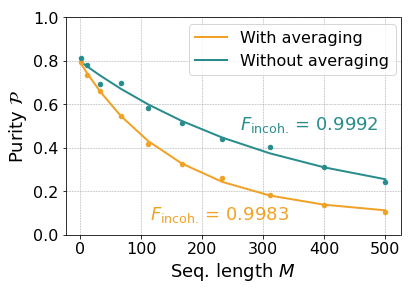

In [204]:
fig,ax = fig_prepare(r"Seq. length $M$", r"Purity $\mathcal{P}$")
ax.plot(M_prb, fun(M_prb, *popts[0]), linestyle="-", linewidth=2, color="#f1a226", label="With averaging")
ax.plot(M_prb, fun(M_prb, *popts[1]), linestyle="-", linewidth=2, color="#298c8c", label="Without averaging")
ax.plot(M_prb, results_mean[:,0], linestyle="", marker=".", markersize=9, color="#f1a226")
ax.plot(M_prb, results_mean[:,1], linestyle="", marker=".", markersize=9, color="#298c8c")
ax.set_ylim(0,1)

ax.annotate(text=r"$F_{\text{incoh.}}$ = "+str(np.round(1-results_errors[0],4)),
            xy=(0,1),
            xytext=(150,70),
            xycoords='figure points',
            fontsize=18,
            color="#f1a226")
ax.annotate(text=r"$F_{\text{incoh.}}$ = "+str(np.round(1-results_errors[1],4)),
            xy=(0,1),
            xytext=(240,160),
            xycoords='figure points',
            fontsize=18,
            color="#298c8c")

fig.legend(loc=[0.45,0.74])

In [205]:
# Filter only protocol 2 and 3
M = figure_data[1]["x0"]
rb_popts = figure_data[1]["y0"][5:15,:]
rb_vals = figure_data[1]["y1"][5:15,:]

In [206]:
color_list1 = ["#f7d9a2", "#f5c26a", "#f1a226", "#d17e16", "#b45b09"]
color_list2 = ["#a6dede", "#63b6b6", "#298c8c", "#1f6f6f", "#155050"]

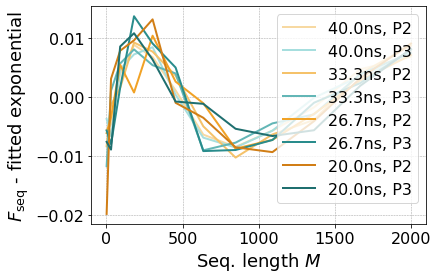

In [207]:
fig,ax = fig_prepare(r"Seq. length $M$", r"$F_\text{seq}$ - fitted exponential")

for i in range(4):
    ax.plot(M, rb_vals[i,:] - fun(M, *rb_popts[i]), linewidth=2, color=color_list1[i], label=f"{np.round(tgs[i],1)}ns, P2")
    ax.plot(M, rb_vals[5+i,:] - fun(M, *rb_popts[5+i]), linewidth=2, color=color_list2[i], label=f"{np.round(tgs[i],1)}ns, P3")

ax.legend()

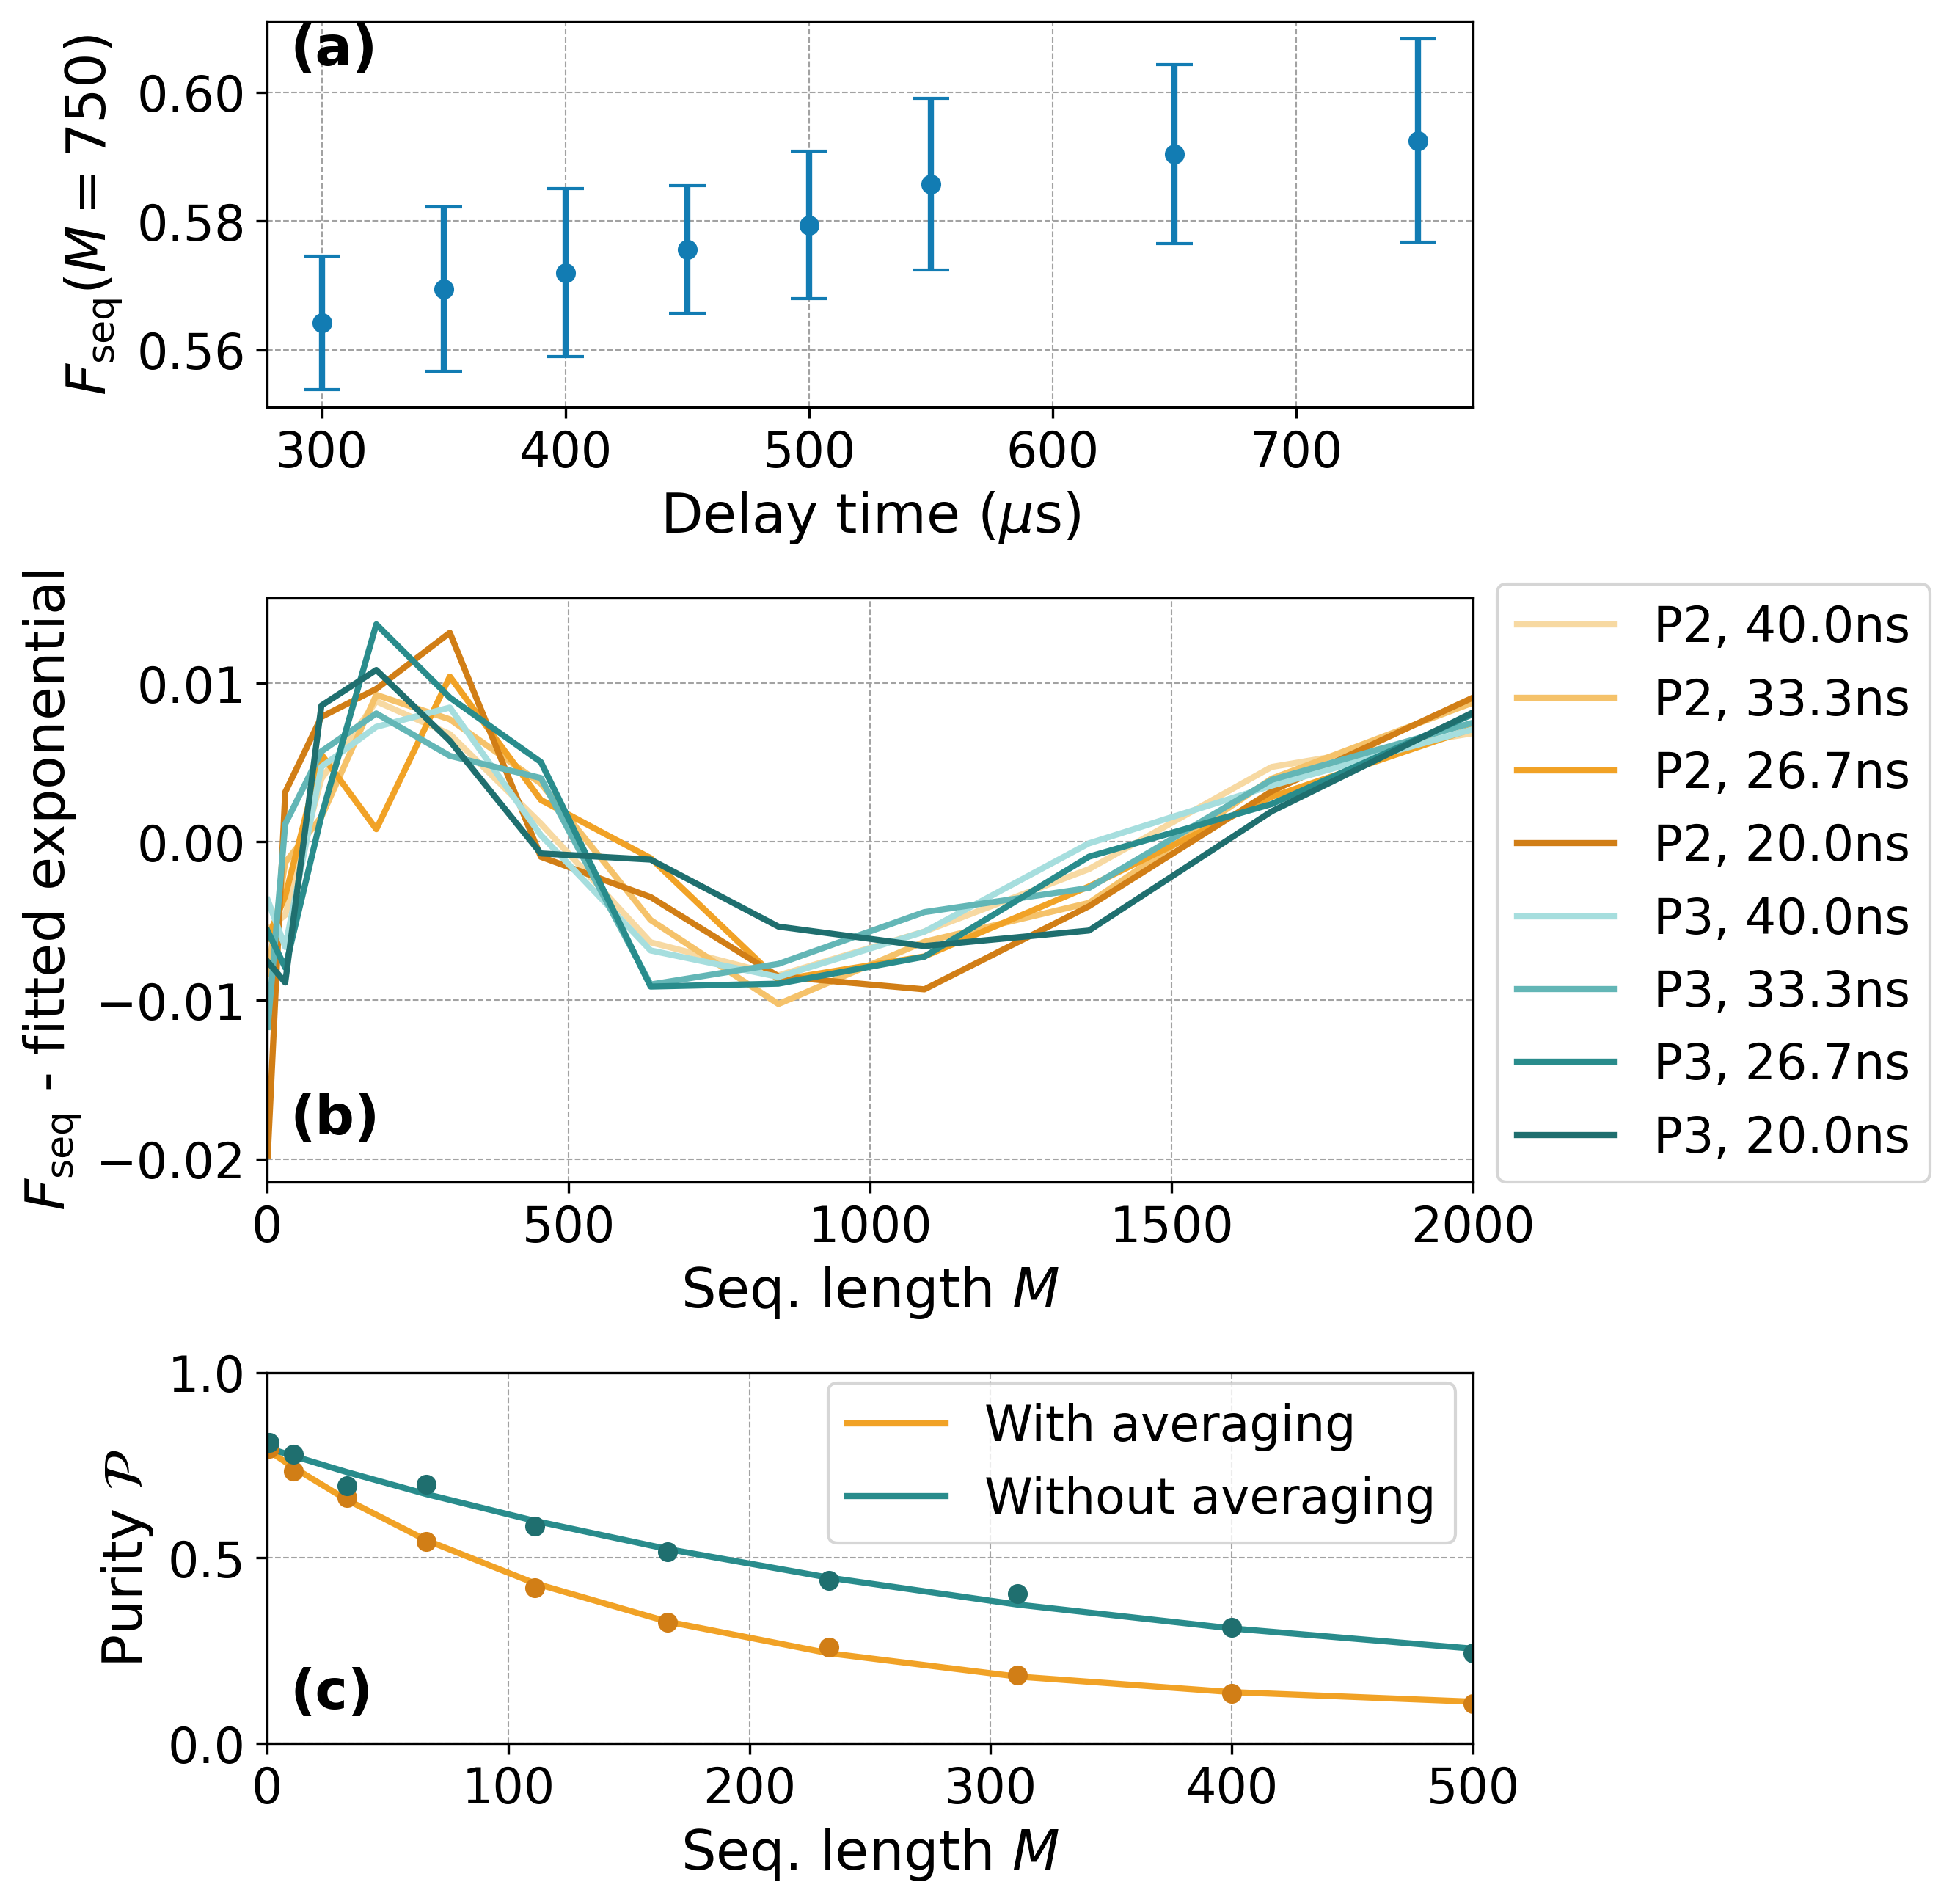

In [ ]:
fig,ax = plt.subplots(3, 1, figsize=(9,9.2), dpi=300, height_ratios=[0.66,1,0.635])

## Plot figure (a)
delay_times = figure_data[3]["x0"]
results_means = figure_data[3]["y0"]
results_stds = figure_data[3]["y1"]
(_, caps1, _) = ax[0].errorbar(delay_times, results_means, yerr=results_stds, linestyle="", marker=".", markersize=11, capsize=6, linewidth=2, color=colors["blue"])

ax[0].set_xlabel(r"Delay time ($\mu$s)")
ax[0].set_ylabel(r"$F_\text{seq}(M=750)$")

## Plot figure (b)
for i in range(4):
    ax[1].plot(M, rb_vals[i,:] - fun(M, *rb_popts[i]), linewidth=2, color=color_list1[i], label=f"P2, {np.round(tgs[i],1)}ns")
for i in range(4):
    ax[1].plot(M, rb_vals[5+i,:] - fun(M, *rb_popts[5+i]), linewidth=2, color=color_list2[i], label=f"P3, {np.round(tgs[i],1)}ns")

# ax[1].legend(loc=[0.45,0.03], ncols=2, columnspacing=0.9)
ax[1].legend(loc=[0.185,0.61], ncols=3, columnspacing=0.9, frameon=False)

ax[1].set_xlabel(r"Seq. length $M$")
ax[1].set_ylabel(r"$F_\text{seq}$ - fitted exponential")
ax[1].set_ylim(-0.02,0.02)

## Plot figure (c)
ax[2].plot(M_prb, fun(M_prb, *popts[0]), linestyle="-", linewidth=2, color="#f1a226", label="With averaging")
ax[2].plot(M_prb, fun(M_prb, *popts[1]), linestyle="-", linewidth=2, color="#298c8c", label="Without averaging")
ax[2].plot(M_prb, results_mean[:,0], linestyle="", marker=".", markersize=11, color=color_list1[-2])
ax[2].plot(M_prb, results_mean[:,1], linestyle="", marker=".", markersize=11, color=color_list2[-2])
ax[2].set_ylim(0,1)
ax[2].set_xlabel(r"Seq. length $M$")
ax[2].set_ylabel(r"Purity $\mathcal{P}$")
ax[2].legend(loc=[0.6,0.54], frameon=False)

# Add 'a' and 'b' labels
ax[0].annotate(text="(a)", 
               xy=(0,1), 
               xytext=(95,601.5), 
               xycoords='figure points', 
               fontsize=18,
               weight="bold")
ax[1].annotate(text="(b)", 
               xy=(0,1), 
               xytext=(95,412), 
               xycoords='figure points', 
               fontsize=18,
               weight="bold")
ax[2].annotate(text="(c)", 
               xy=(0,1), 
               xytext=(95,160), 
               xycoords='figure points', 
               fontsize=18,
               weight="bold")

ax[1].set_xlim(0,2000)
ax[1].set_xticks([0,500,1000,1500,2000])
ax[2].set_xlim(0,500)
# ax[2].set_xticks([0])

fig.tight_layout()
fig.savefig("rb-experiment-appendix.png", dpi=200)